In [80]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Times New Roman']
plt.rcParams['figure.dpi'] = 500
plt.rcParams['text.color'] = 'k'
plt.rcParams['axes.labelcolor'] = 'w'
plt.rcParams['xtick.color'] = 'k'
plt.rcParams['ytick.color'] = 'k'
plt.rcParams['axes.edgecolor'] = 'k'
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['axes.facecolor'] = 'w'
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import LogNorm
from matplotlib.patches import FancyArrowPatch
import matplotlib.colors as colors
from astropy.visualization import SqrtStretch, LinearStretch, LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
import pandas as pd
import re
from astropy.io import fits
import os
from scipy.ndimage import map_coordinates
from scipy.stats import binned_statistic
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
from pathlib import Path

from matplotlib.lines import Line2D
os.chdir("/Users/ainsleylewis/Documents/Astronomy/IllustrisTNG Lens Modelling")

In [81]:
# Define the lens corresponding parameters (order preserved)
# POW
pow_params = ['$z_{s,fid}$', 'x', 'y', 'e', '$θ_{e}$', '$r_{Ein}$', '$\gamma$ (PWI)']

# SIE
sie_params = ['$\sigma$', 'x', 'y', 'e', '$θ_{e}$', '$r_{core}$', 'NaN']

# NFW
nfw_params = ['M', 'x', 'y', 'e', '$θ_{e}$', 'c or $r_{s}$', 'NaN']

# EIN
ein_params = ['M', 'x', 'y', 'e', '$θ_{e}$', 'c or $r_{s}$', r'$\alpha_{e}$']

# SHEAR 
shear_params = ['$z_{s,fid}$', 'x', 'y', '$\gamma$', '$θ_{\gamma}$', 'NaN', '$\kappa$']

# Sersic
sersic_params = ['$M_{tot}$', 'x', 'y', 'e', '$θ_{e}$', '$r_{e}$', '$n$']

# Cored SIE
cored_sie_params = ['M', 'x', 'y', 'e', '$θ_{e}$', '$r_{core}$', 'NaN']

# Multipoles
mpole_params = ['$z_{s,fid}$', 'x', 'y', '$\epsilon$', '$θ_{m}$', 'm', 'n']

model_list = ['POW', 'SIE', 'ANFW', 'EIN', 'PERT', 'SERS', 'MPOLE']
model_params = {
    'POW': pow_params,
    'SIE': sie_params,
    'ANFW': nfw_params,
    'EIN': ein_params,
    'PERT': shear_params,
    'SERS': sersic_params,
    'MPOLE' : mpole_params
}


In [82]:
# Define function to make both tables
def rms_extract(model_ver, model_path, constraint):
    global pos_rms, mag_rms
    # Load the data
    with open(model_path + '/' + model_ver + '_optresult' + '.dat', 'r') as file:
        opt_result = file.readlines()

    # Find the last line with 'optimize' in it
    last_optimize_index = None
    for idx in range(len(opt_result) - 1, -1, -1):
        if 'optimize' in opt_result[idx]:
            last_optimize_index = idx
            last_optimize_line = opt_result[idx]
            break
    if last_optimize_index is None:
        raise ValueError("No line with 'optimize' found in the file.")

    # Extract everything after the last 'optimize' line
    opt_result = opt_result[last_optimize_index + 1:]

    # Count the number of lines that start with 'lens'
    lens_count = sum(1 for line in opt_result if line.startswith('lens'))

    # Initialize a dictionary to hold the lens parameters
    lens_params_dict = {}

    # Extract the lens parameters
    lens_params = []
    for line in opt_result:
        if line.startswith('lens'):
            parts = re.split(r'\s+', line.strip())
            lens_name = parts[1]
            params = [float(x) for x in parts[2:]]

            # Store the parameters in the dictionary
            lens_params_dict[lens_name] = params
            lens_params.append((lens_name, params))

    # Remove the first lens parameter
    if lens_params:
        for i in range(len(lens_params)):
            lens_name, params = lens_params[i]
            lens_params_dict[lens_name] = params[1:]

    # Number of len profiles
    num_lens_profiles = len(lens_params_dict)

    # Use generic column names: param1, param2, ...
    df = pd.DataFrame()
    rows = []
    max_param_len = 0

    for lens_name, params in lens_params_dict.items():
        row = {'Lens Name': lens_name}
        for i, val in enumerate(params):
            row[f'param{i+1}'] = val
        rows.append(row)
        if len(params) > max_param_len:
            max_param_len = len(params)

    columns = ['Lens Name'] + [f'param{i+1}' for i in range(max_param_len)]
    df = pd.DataFrame(rows, columns=columns)
    
    # Load the input parameters from the Python file
    with open('Test/POS+MAG/SIE+SHEAR/pos_point.py', 'r') as file:
        py = file.readlines()

    # Extracting the input parameters from the Python file
    set_lens_lines = [line for line in py if line.startswith('glafic.set_lens(')]
    if not set_lens_lines:
        raise ValueError("No lines starting with 'glafic.set_lens(' found in the file.")

    set_lens_params = []
    for line in set_lens_lines:
        match = re.search(r'set_lens\((.*?)\)', line)
        if match:
            params_str = match.group(1)
            params = [param.strip() for param in params_str.split(',')]
            set_lens_params.append(params)
        else:
            raise ValueError(f"No valid parameters found in line: {line.strip()}")

    # Store the parameters in a dictionary
    set_lens_dict = {}
    for params in set_lens_params:
        if len(params) < 3:
            raise ValueError(f"Not enough parameters found in line: {params}")
        lens_name = params[1].strip("'\"")  # Remove quotes from lens name
        lens_params = [float(x) for x in params[2:]]  # Skip index and lens name
        set_lens_dict[lens_name] = lens_params

    # Remove the first lens parameter
    if set_lens_dict:
        for lens_name, params in set_lens_dict.items():
            set_lens_dict[lens_name] = params[1:]  # Remove the first parameter (index)

    # Use generic column names: param1, param2, ...
    df_input = pd.DataFrame()
    rows_input = []
    max_param_len_input = 0
    for lens_name, params in set_lens_dict.items():
        row = {'Lens Name': lens_name}
        for i, val in enumerate(params):
            row[f'param{i+1}'] = val
        rows_input.append(row)
        if len(params) > max_param_len_input:
            max_param_len_input = len(params)
    columns_input = ['Lens Name'] + [f'param{i+1}' for i in range(max_param_len_input)]
    df_input = pd.DataFrame(rows_input, columns=columns_input)
    
    # Extract input flags from the Python file
    set_flag_lines = [line for line in py if line.startswith('glafic.setopt_lens(')]
    if not set_flag_lines:
        raise ValueError("No lines starting with 'glafic.setopt_lens(' found in the file.")
    set_flag_params = []
    for line in set_flag_lines:
        match = re.search(r'setopt_lens\((.*?)\)', line)
        if match:
            params_str = match.group(1)
            params = [param.strip() for param in params_str.split(',')]
            set_flag_params.append(params)
        else:
            raise ValueError(f"No valid parameters found in line: {line.strip()}")
    
    # Store the parameters in a dictionary
    set_flag_dict = {}
    for params in set_flag_params:
        if len(params) < 2:
            raise ValueError(f"Not enough parameters found in line: {params}")
        # The lens name is not present in setopt_lens, so use the lens index to map to set_lens_dict
        lens_index = params[0].strip("'\"")
        # Find the lens name corresponding to this index from set_lens_params
        lens_name = None
        for lens_params in set_lens_params:
            if lens_params[0].strip("'\"") == lens_index:
                lens_name = lens_params[1].strip("'\"")
                break
        if lens_name is None:
            raise ValueError(f"Lens name for index {lens_index} not found in set_lens_params")
        flag = ','.join(params[1:])  # Join all flag values as a string
        set_flag_dict[lens_name] = flag
   
    # Remove the first flag parameter
    if set_flag_dict:
        for lens_name, flag in set_flag_dict.items():
            flag_parts = flag.split(',')
            set_flag_dict[lens_name] = ','.join(flag_parts[1:])  # Remove the first flag parameter
    
    # Dynamically create columns: 'Lens Name', 'flag1', 'flag2', ..., based on the maximum number of flags
    df_flag = pd.DataFrame()
    rows_flag = []
    max_flag_len = 0
    
    # First, determine the maximum number of flags
    for flag in set_flag_dict.values():
        flag_parts = flag.split(',')
        if len(flag_parts) > max_flag_len:
            max_flag_len = len(flag_parts)
    for lens_name, flag in set_flag_dict.items():
        flag_parts = flag.split(',')
        row = {'Lens Name': lens_name}
        for i, val in enumerate(flag_parts):
            row[f'flag{i+1}'] = val
        rows_flag.append(row)
    columns_flag = ['Lens Name'] + [f'flag{i+1}' for i in range(max_flag_len)]  
    df_flag = pd.DataFrame(rows_flag, columns=columns_flag)
    
    # Combine all dataframes into a list of dataframes for each lens
    dfs = []
    
    for i in range(num_lens_profiles):
        lens_name = df['Lens Name'][i]
        
        # Find the model type (case-insensitive match)
        model_type = None
        for m in model_list:
            if m.lower() == lens_name.lower():
                model_type = m
                break
        if model_type is None:
            continue

        symbols = model_params[model_type][:7]
        # Row 2: input
        row_input = pd.DataFrame([df_input.iloc[i, 1:8].values], columns=symbols)
        # Row 3: output
        row_output = pd.DataFrame([df.iloc[i, 1:8].values], columns=symbols)
        # Row 4: flags
        row_flags = pd.DataFrame([df_flag.iloc[i, 1:8].values], columns=symbols)

        # Stack vertically, add a label column for row type
        lens_df = pd.concat([
            row_input.assign(Type='Input'),
            row_output.assign(Type='Output'),
            row_flags.assign(Type='Flag')
        ], ignore_index=True)
        lens_df.insert(0, 'Lens Name', lens_name)
        
        # Move 'Type' to the second column
        cols = lens_df.columns.tolist()
        cols.insert(1, cols.pop(cols.index('Type')))
        lens_df = lens_df[cols]
        dfs.append(lens_df)
    
    # Anomaly Calculation
    columnn_names = ['x', 'y', 'mag', 'pos_err', 'mag_err', '1', '2', '3']
    obs_point = pd.read_csv('obs_point/obs_point_(POS+FLUX).dat', delim_whitespace=True, header=None, skiprows=1, names=columnn_names)
    out_point = pd.read_csv(model_path + '/' + model_ver + '_point.dat', delim_whitespace=True, header=None, skiprows=1, names=columnn_names)
    out_point.drop(columns=['mag_err', '1', '2', '3'], inplace=True)

    # Drop rows in obs_point where the corresponding out_point['mag'] < 1
    mask = abs(out_point['mag']) >= 1
    out_point = out_point[mask[:len(out_point)]].reset_index(drop=True)
    out_point['x_diff'] = abs(out_point['x'] - obs_point['x'])
    out_point['y_diff'] = abs(out_point['y'] - obs_point['y'])
    out_point['mag_diff'] = abs(abs(out_point['mag']) - abs(obs_point['mag']))
    out_point['pos_sq'] = np.sqrt(out_point['x_diff']**2 + out_point['y_diff']**2)  # Plotted on graph
    

    # RMS
    pos_rms = np.average(out_point['pos_sq'])

    mag_rms = np.average(np.sqrt(out_point['mag_diff']**2))

    return pos_rms, mag_rms, dfs

In [83]:
m = [0.1, 0.2, 0.3, 0.4, 0.5]
n = [0, 50, 100, 150, 200]
o = [0.1, 0.2, 0.3, 0.4, 0.5]

columns = ['x', 'y', 'm', 'm_err']

df = pd.DataFrame(columns=['strength', 'pa', 'kappa', 'num_images', 'pos_rms', 'mag_rms', 't_shear_str', 't_shear_pa', 't_shear_kappa', 'sie_vel_disp', 'sie_pa', 'sie_ell'])

for i in range(len(m)):
    for j in range(len(n)):
        for k in range(len(o)):
            model_path = 'TEST/Simulation/'
            model_ver = 'SIE_POS_SHEAR_' + str(m[i]) + '_' + str(n[j]) + '_' + str(o[k]) 

            if 'POS+FLUX' in model_ver:
                constraint = 'pos_flux'
            elif 'POS' in model_ver:
                constraint = 'pos'

            pos_rms, mag_rms, dfs = rms_extract(model_ver, model_path, constraint)

            file_name = f"Test/Simulation/SIE_POS_SHEAR_{m[i]}_{n[j]}_{o[k]}_point.dat"
            if os.path.exists(file_name):
                data = pd.read_csv(file_name, delim_whitespace=True, skiprows=1, header=None, names=columns)
                num_images = len(data)
                df = pd.concat([df, pd.DataFrame({
                    'strength': [m[i]],
                    'pa': [n[j]],
                    'kappa': [o[k]],
                    'num_images': [num_images],
                    'pos_rms': [pos_rms],
                    'mag_rms': [mag_rms],
                    't_shear_str': dfs[1]['$\gamma$'][1],
                    't_shear_pa': dfs[1]['$θ_{\gamma}$'][1],
                    't_shear_kappa': dfs[1]['$\kappa$'][1],
                    'sie_vel_disp': dfs[0]['$\sigma$'][1],
                    'sie_pa': dfs[0]['$θ_{e}$'][1],
                    'sie_ell': dfs[0]['e'][1]
                })], ignore_index=True)
                if data.empty:
                    print(f"File {file_name} is empty.")
                else:
                    print(f"File {file_name} exists and is not empty.")
            else:
                print(f"File {file_name} does not exist.")

File Test/Simulation/SIE_POS_SHEAR_0.1_0_0.1_point.dat exists and is not empty.
File Test/Simulation/SIE_POS_SHEAR_0.1_0_0.2_point.dat exists and is not empty.
File Test/Simulation/SIE_POS_SHEAR_0.1_0_0.3_point.dat exists and is not empty.
File Test/Simulation/SIE_POS_SHEAR_0.1_0_0.4_point.dat exists and is not empty.
File Test/Simulation/SIE_POS_SHEAR_0.1_0_0.5_point.dat exists and is not empty.
File Test/Simulation/SIE_POS_SHEAR_0.1_50_0.1_point.dat exists and is not empty.
File Test/Simulation/SIE_POS_SHEAR_0.1_50_0.2_point.dat exists and is not empty.
File Test/Simulation/SIE_POS_SHEAR_0.1_50_0.3_point.dat exists and is not empty.
File Test/Simulation/SIE_POS_SHEAR_0.1_50_0.4_point.dat exists and is not empty.
File Test/Simulation/SIE_POS_SHEAR_0.1_50_0.5_point.dat exists and is not empty.
File Test/Simulation/SIE_POS_SHEAR_0.1_100_0.1_point.dat exists and is not empty.
File Test/Simulation/SIE_POS_SHEAR_0.1_100_0.2_point.dat exists and is not empty.
File Test/Simulation/SIE_POS_SH

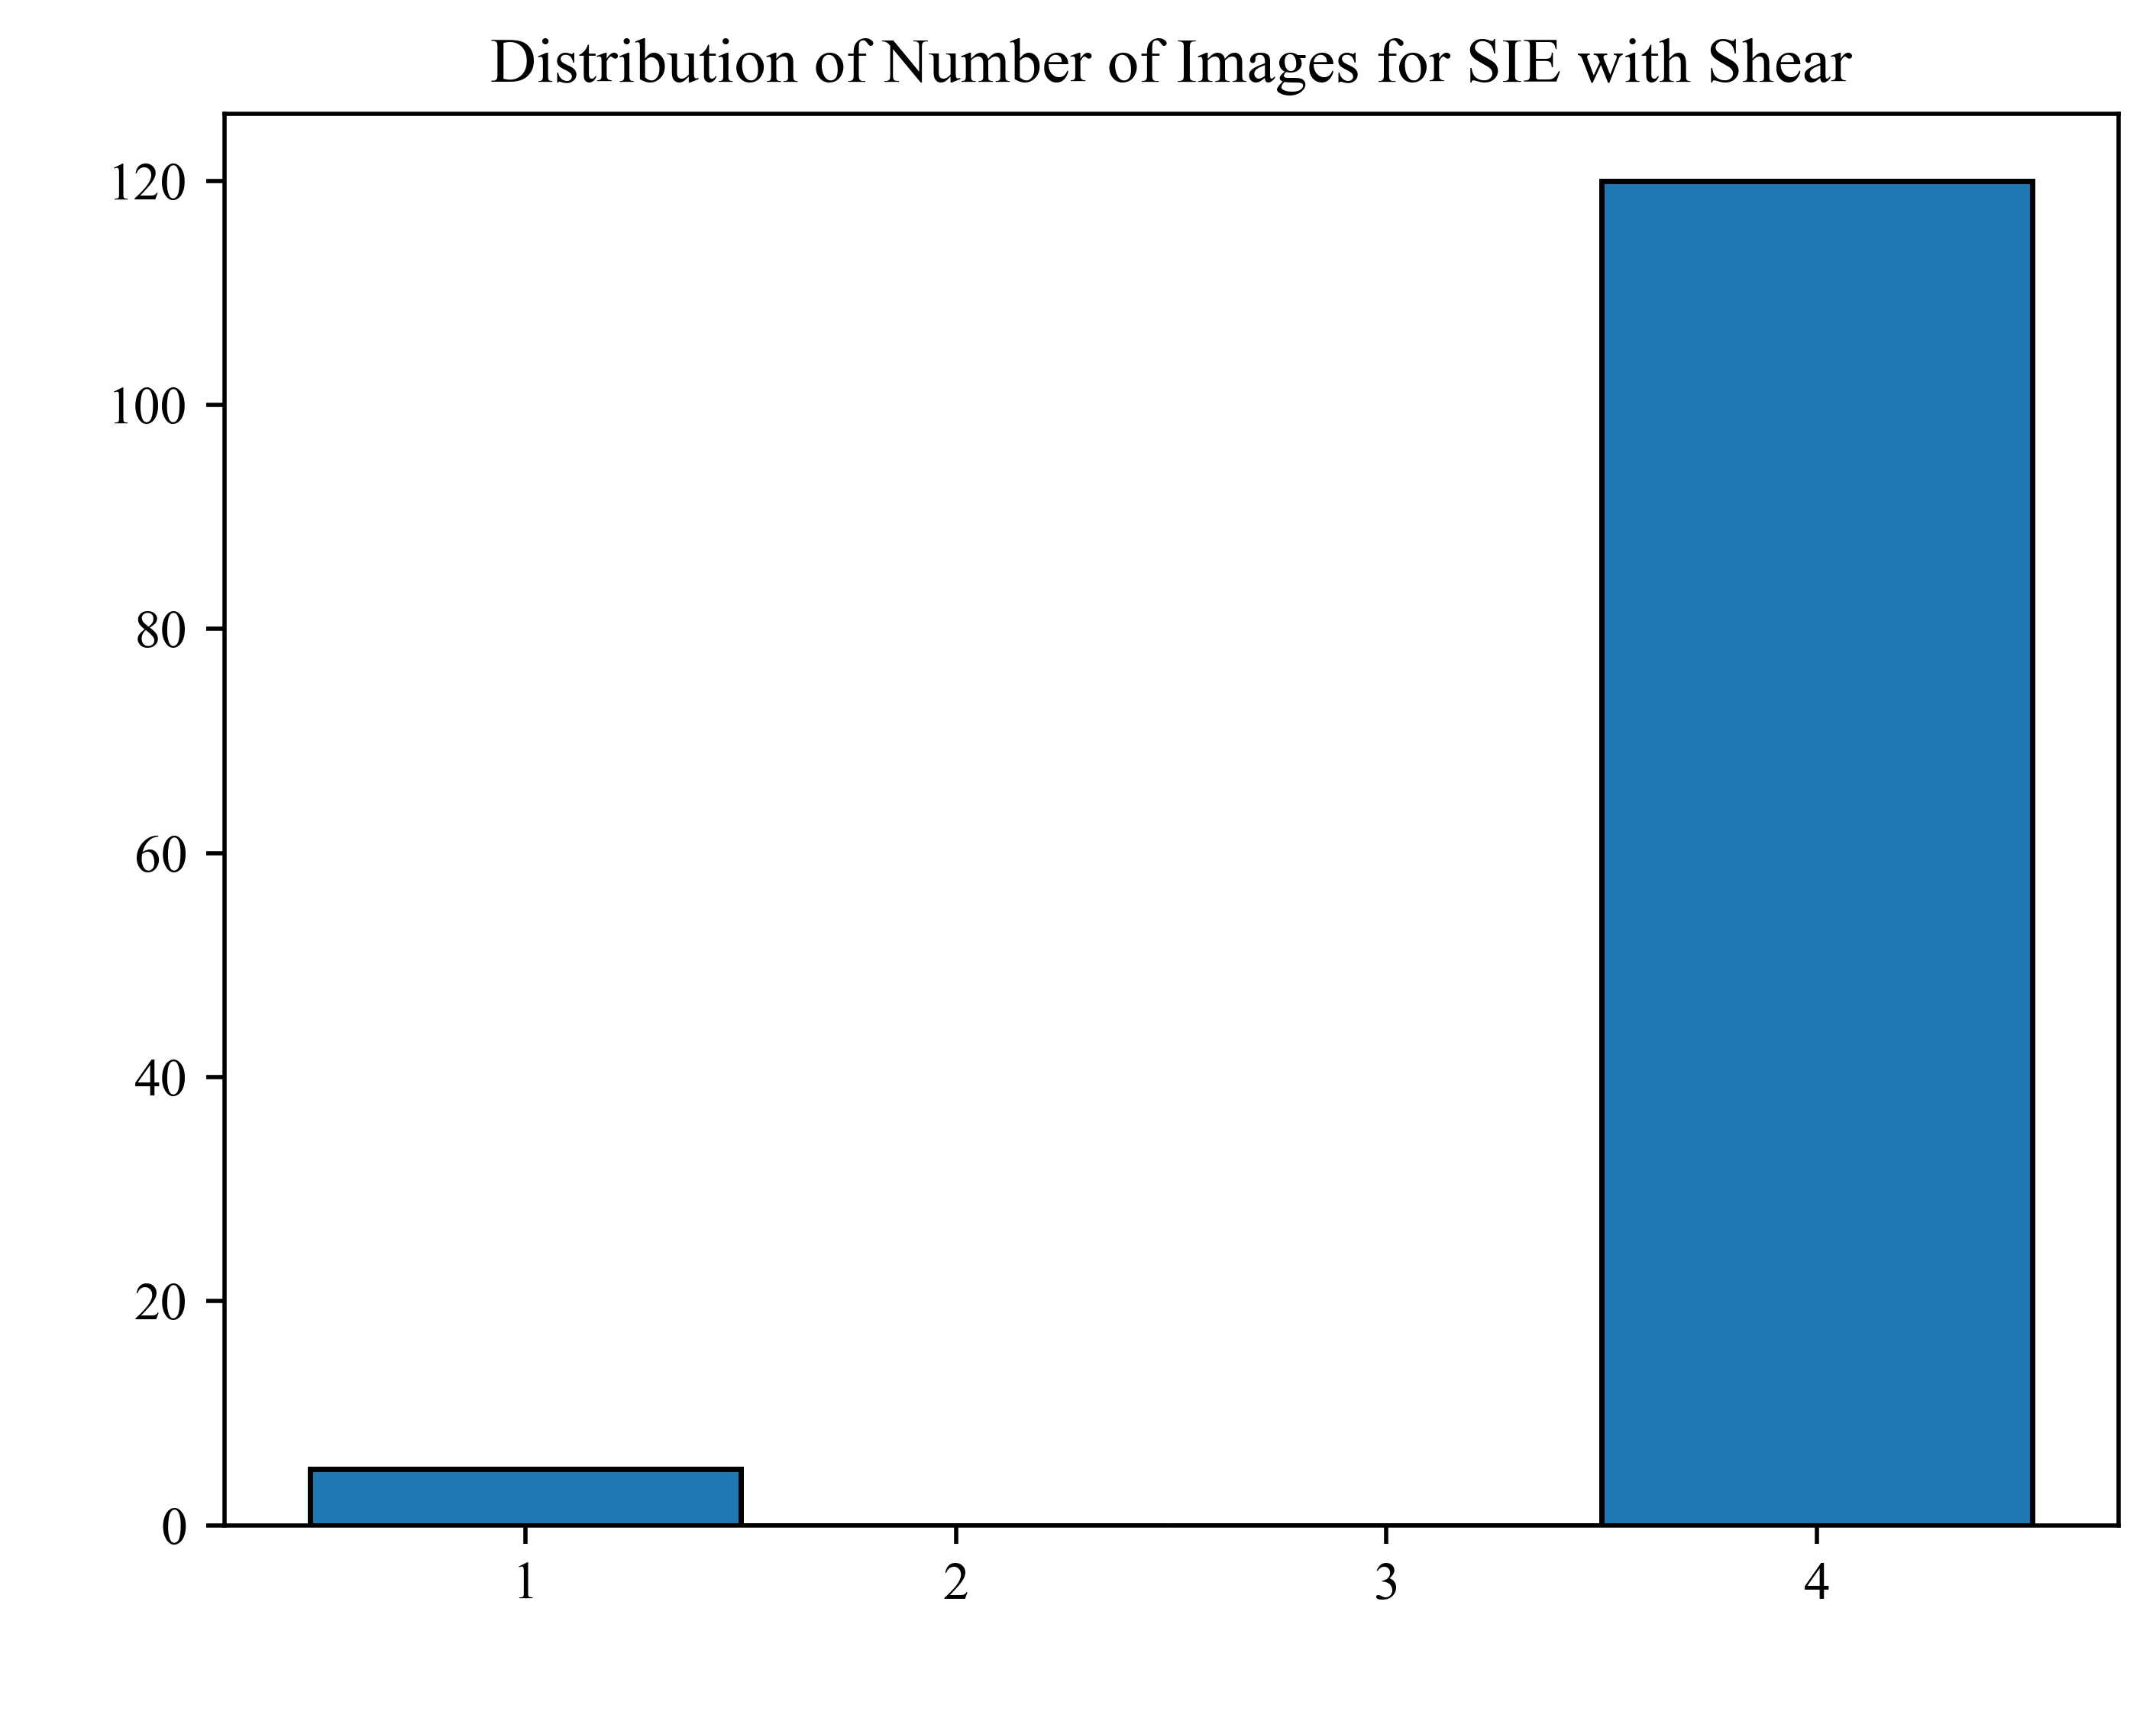

In [84]:
plt.hist(df['num_images'], bins=range(1, 6), align='left', edgecolor='black')
plt.xlabel('Number of Images')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Images for SIE with Shear')
plt.xticks([1,2,3,4])
plt.show()

In [85]:
mask = df['num_images'] == 4
filtered_df_0 = df[mask]
filtered_df_0 = filtered_df_0.reset_index(drop=True)
filtered_df_0

,strength,pa,kappa,num_images,pos_rms,mag_rms,t_shear_str,t_shear_pa,t_shear_kappa,sie_vel_disp,sie_pa,sie_ell
0,0.1,0,0.1,4,0.000031,35.244050,0.028655,-33.03519,0.245832,137.10080,35.153610,0.092948
1,0.1,0,0.2,4,0.000031,51.716325,0.036504,-28.18986,0.188278,142.22810,51.577170,0.102360
2,0.1,0,0.3,4,0.000031,40.176750,0.038535,-28.63343,0.125613,147.61520,49.950020,0.099668
3,0.1,0,0.4,4,0.000031,106.327550,0.019307,-31.61485,0.512074,110.27230,39.533540,0.092160
4,0.1,0,0.5,4,0.000031,70.812975,0.024378,-30.95932,0.396533,122.63390,41.710050,0.092580
...,...,...,...,...,...,...,...,...,...,...,...,...
115,0.5,150,0.4,4,0.002835,408.067425,0.049667,169.93800,0.154751,145.42350,79.626500,0.157836
116,0.5,200,0.1,4,0.000031,3.981475,0.130262,271.29250,0.157624,150.66980,-1.780392,0.651223
117,0.5,200,0.2,4,0.000031,101.585975,0.010957,310.98750,0.645978,94.01663,192.352300,0.153196
118,0.5,200,0.3,4,0.000031,134.404400,0.010658,105.97580,0.769933,76.09379,2.743096,0.302818


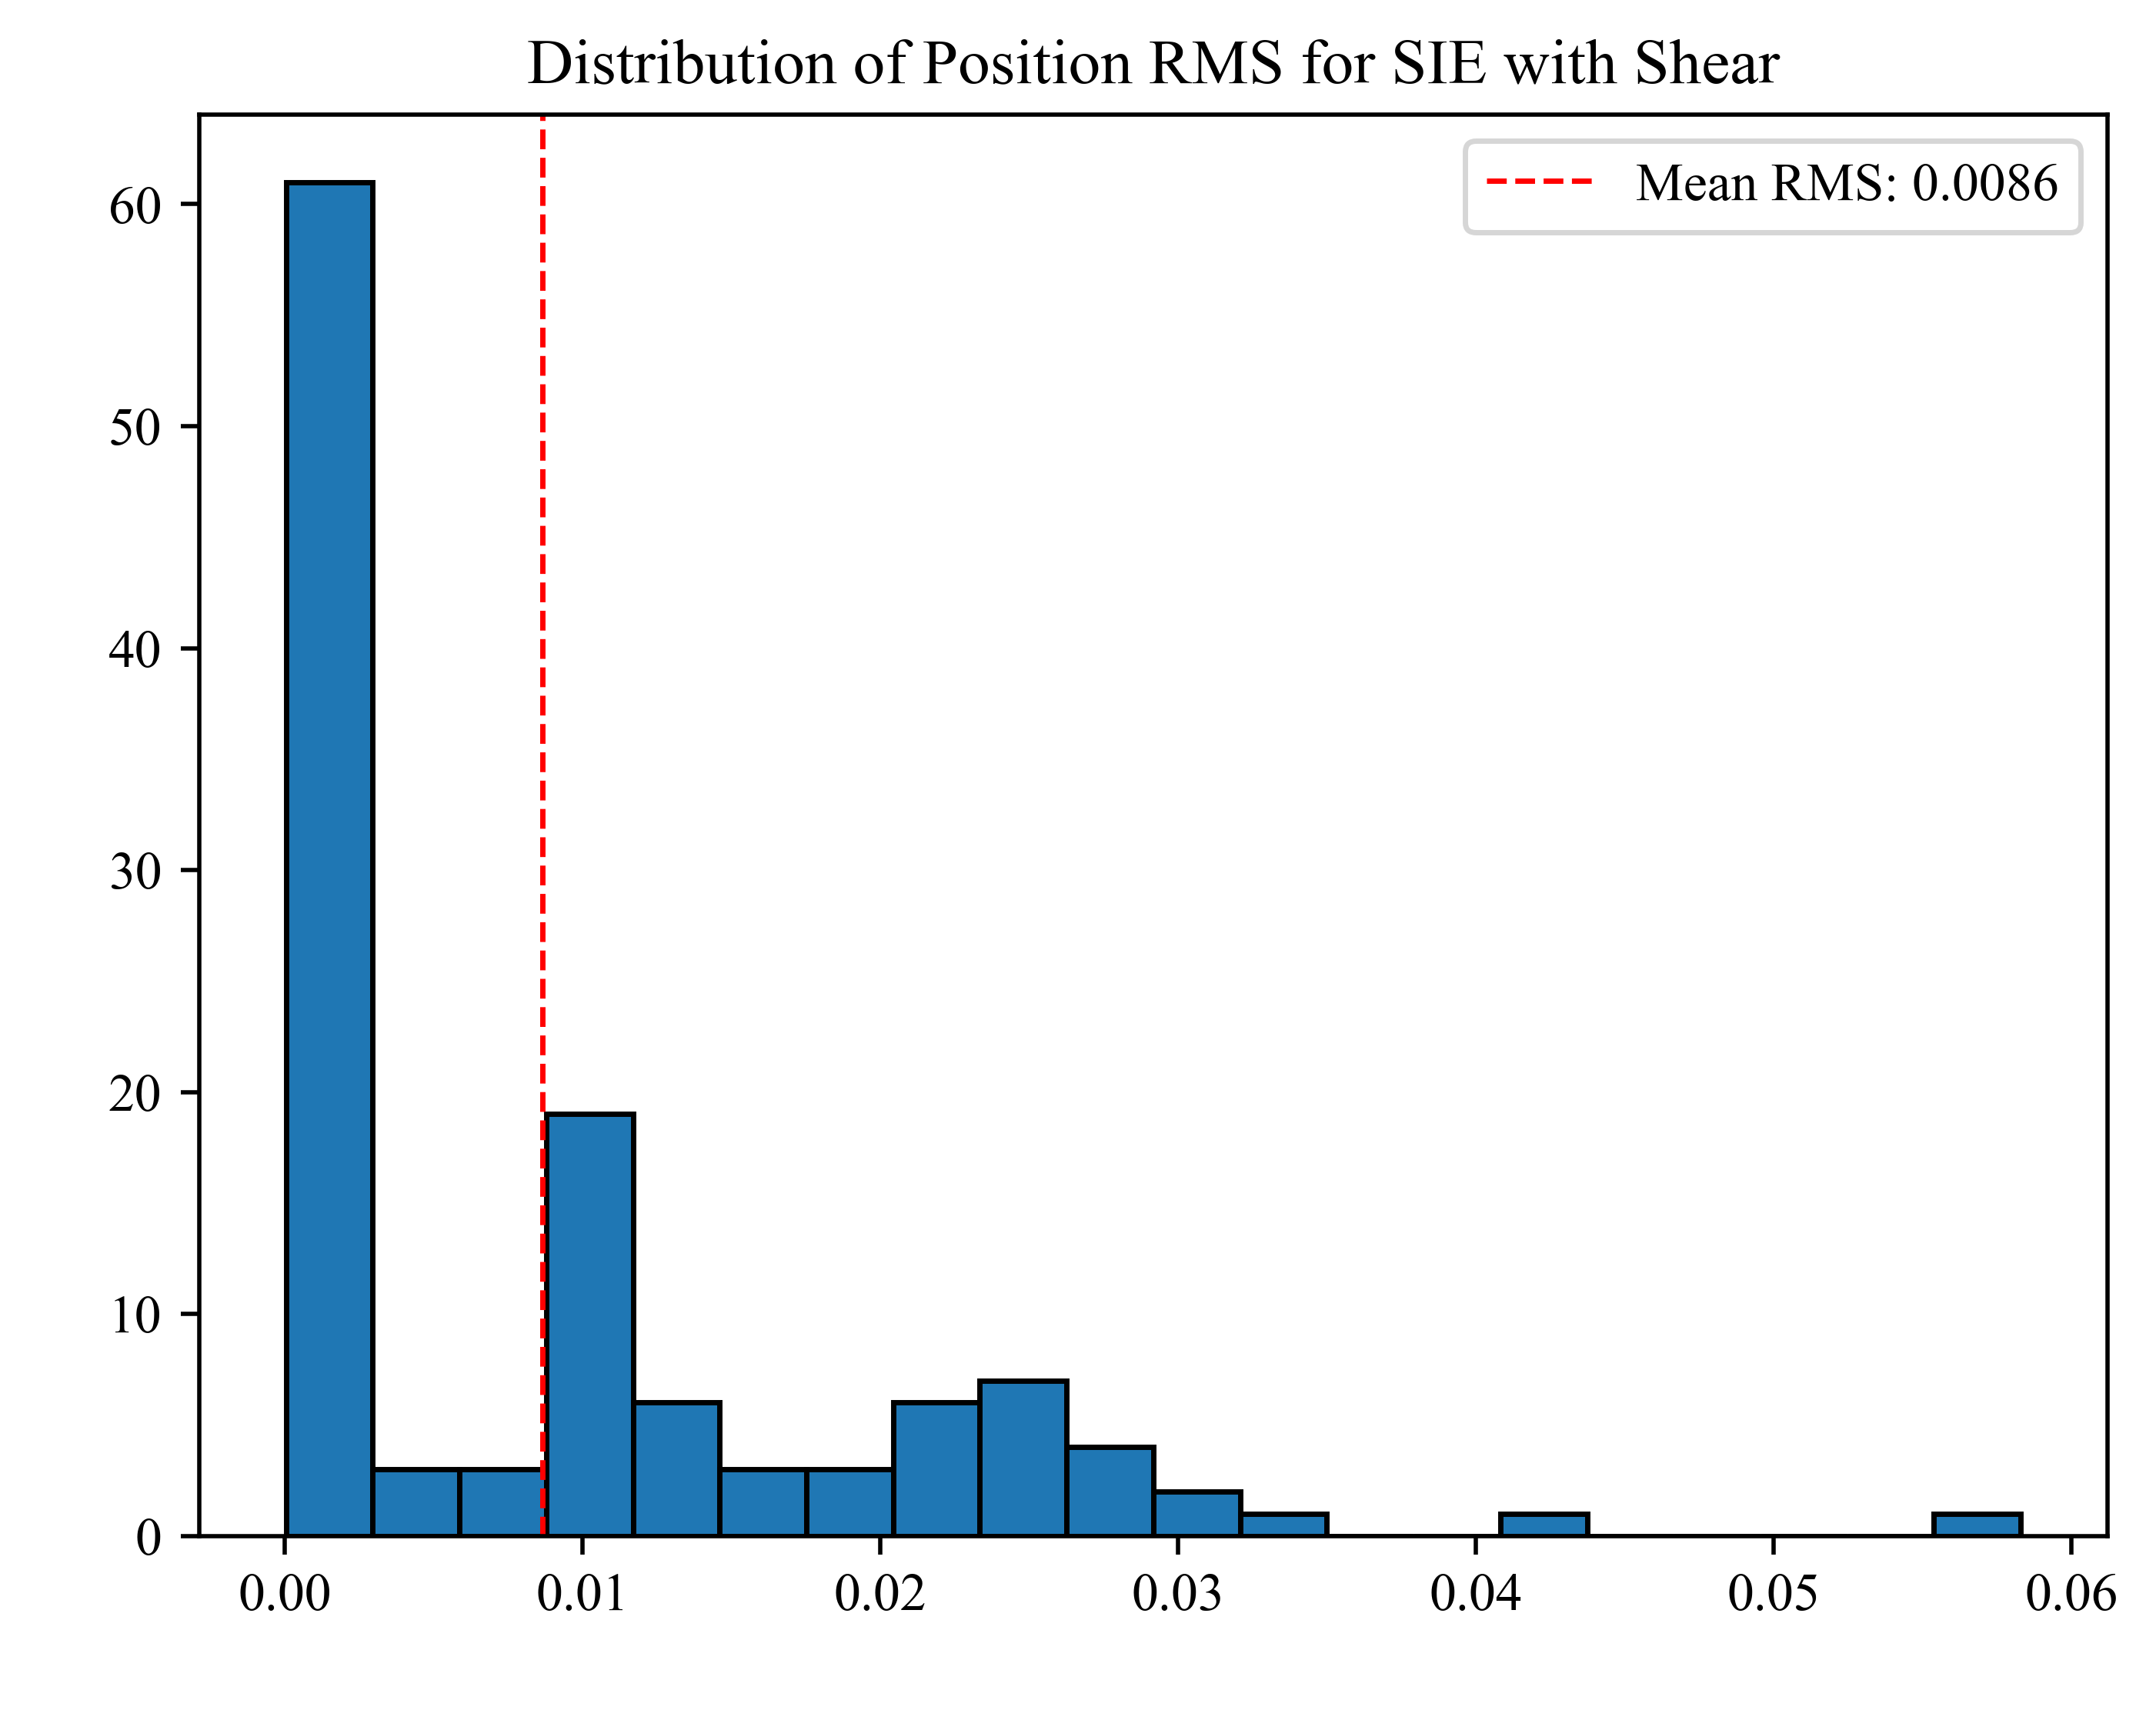

In [86]:
plt.hist(filtered_df_0['pos_rms'], bins=20, edgecolor='black')
plt.axvline(filtered_df_0['pos_rms'].mean(), color='r', linestyle='dashed', linewidth=1, label='Mean RMS: ' + str(round(filtered_df_0['pos_rms'].mean(), 4)))
plt.xlabel('Position RMS')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of Position RMS for SIE with Shear')
plt.show()

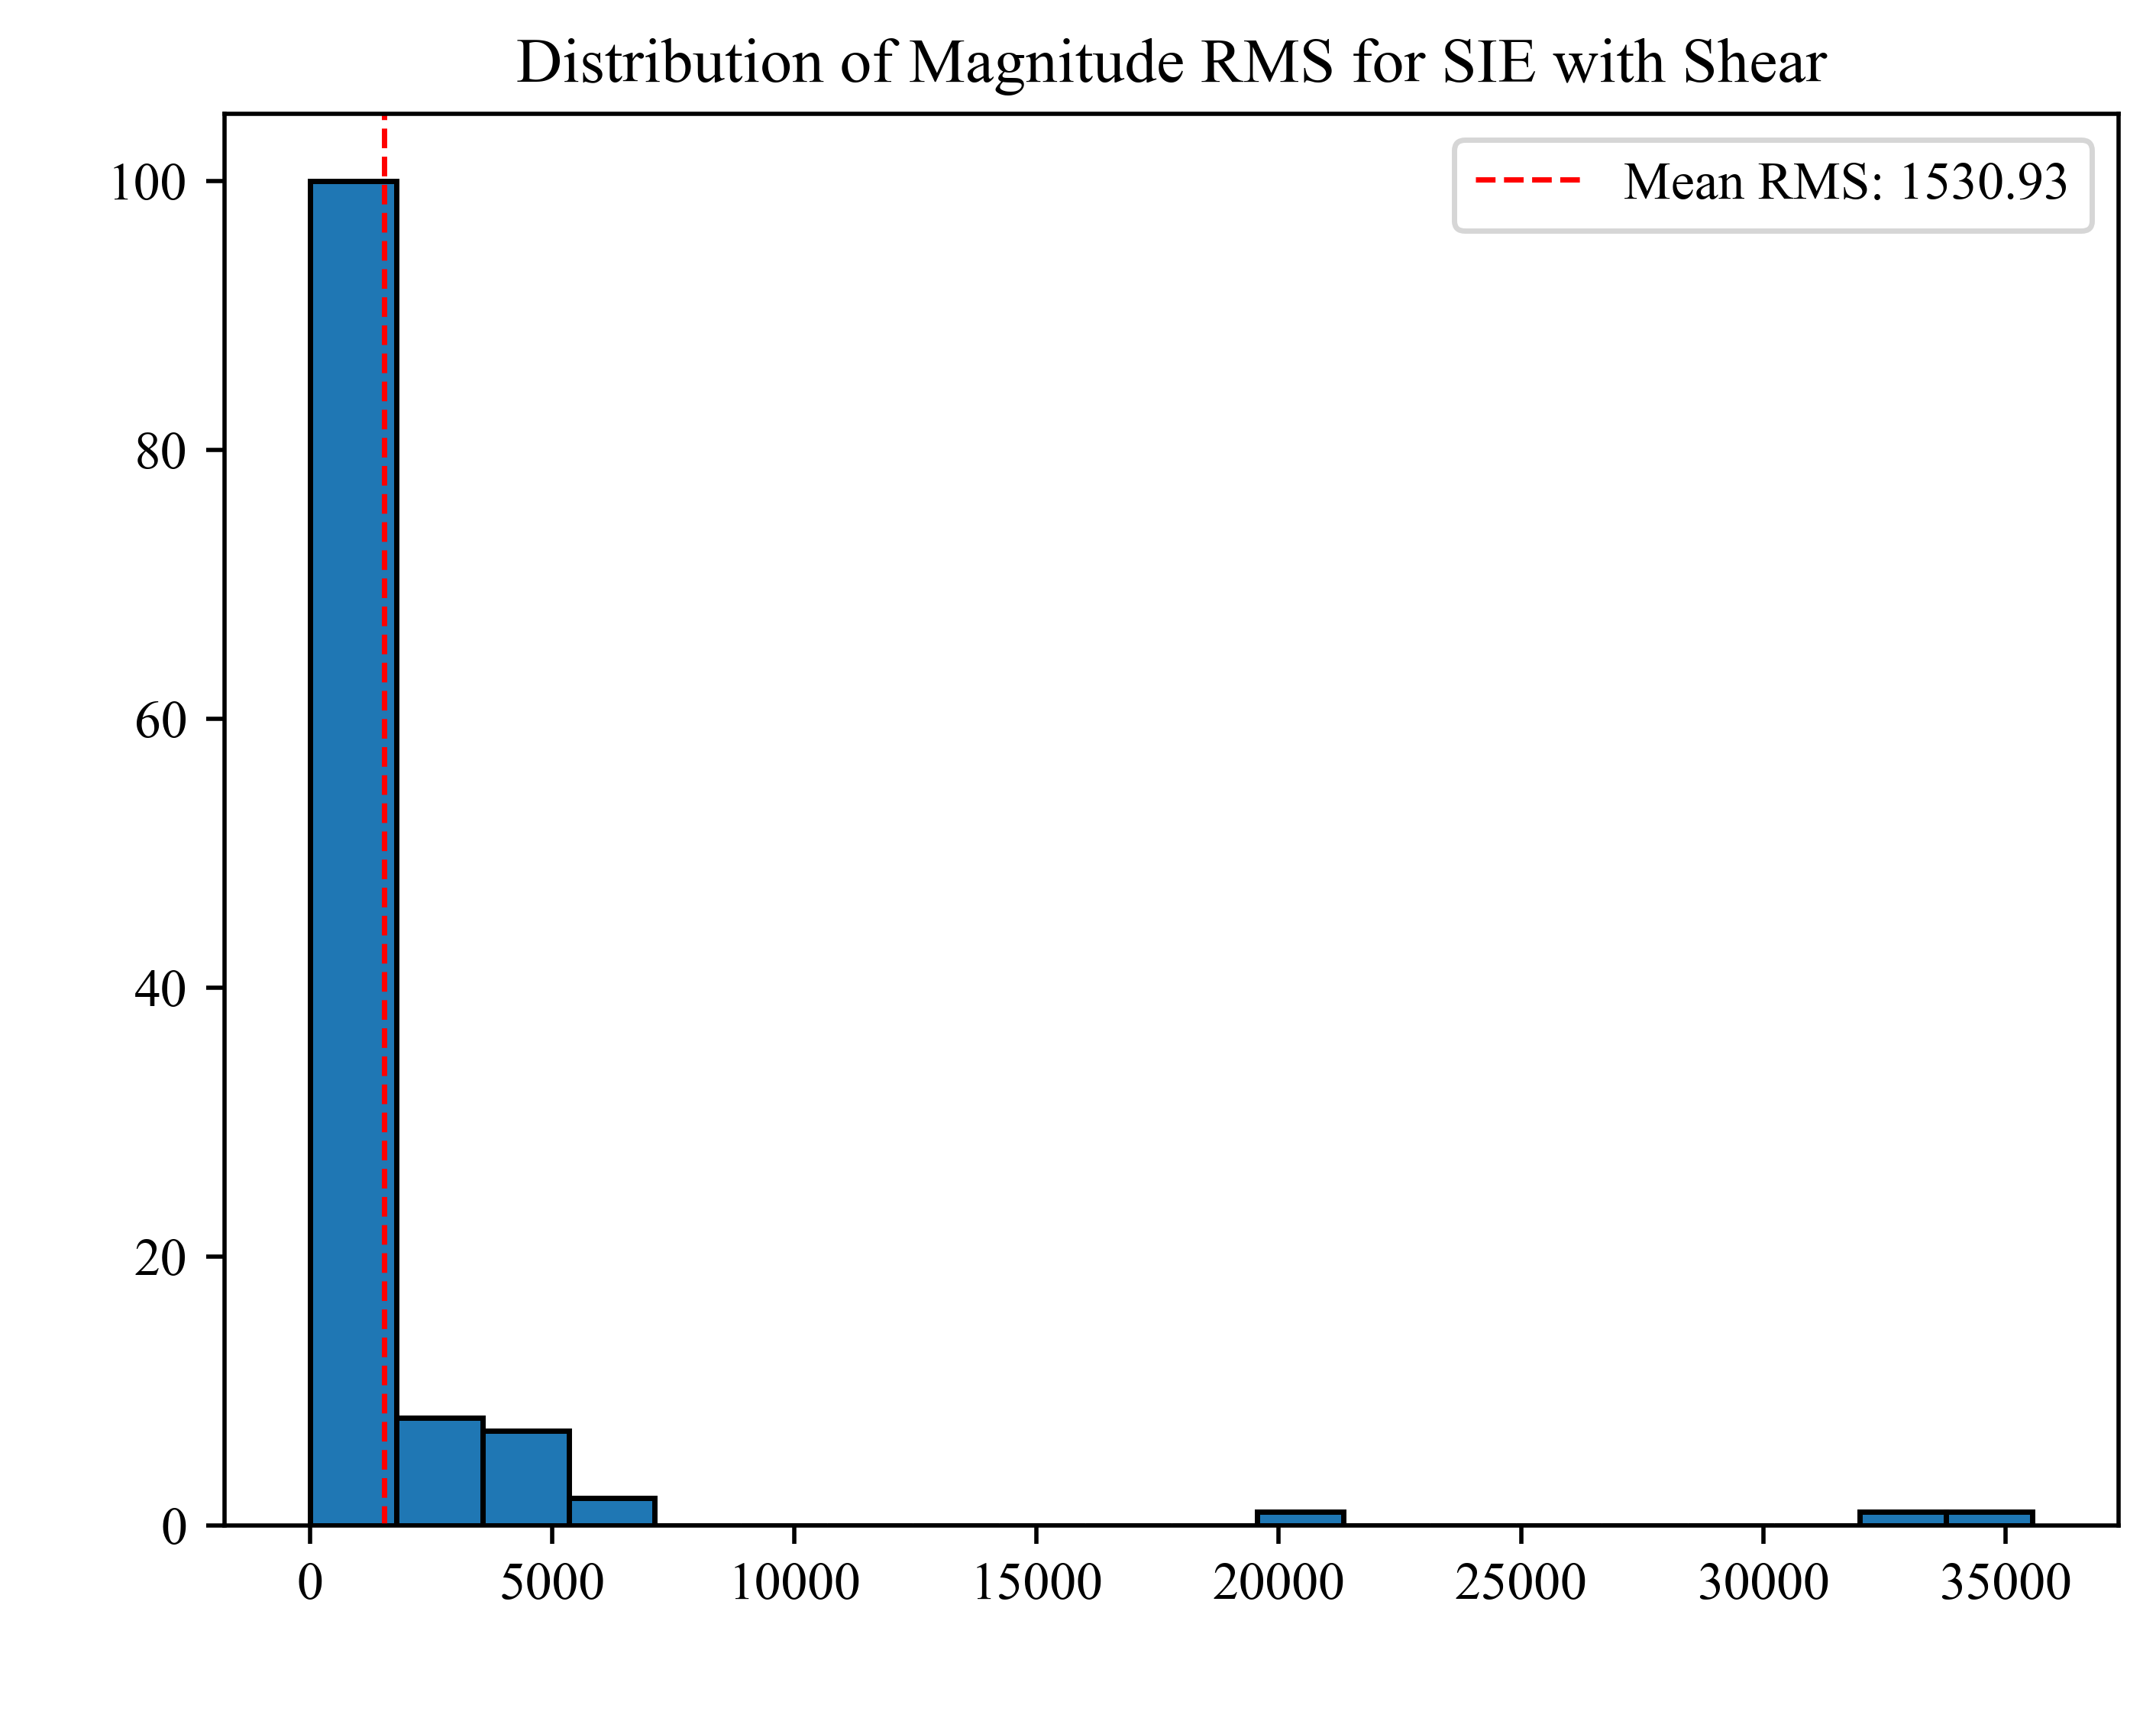

In [87]:
plt.hist(filtered_df_0['mag_rms'], bins=20, edgecolor='black')
plt.axvline(filtered_df_0['mag_rms'].mean(), color='r', linestyle='dashed', linewidth=1, label='Mean RMS: ' + str(round(filtered_df_0['mag_rms'].mean(), 2)))
plt.xlabel('Magnitude RMS')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of Magnitude RMS for SIE with Shear')
plt.show()

In [88]:
mask2 = filtered_df_0['pos_rms']  == 3.101229586803652e-05
filtered_df = filtered_df_0[mask2]
filtered_df = filtered_df.reset_index(drop=True)
filtered_df

,strength,pa,kappa,num_images,pos_rms,mag_rms,t_shear_str,t_shear_pa,t_shear_kappa,sie_vel_disp,sie_pa,sie_ell
0,0.1,0,0.1,4,0.000031,35.244050,0.028655,-33.03519,0.245832,137.10080,35.153610,0.092948
1,0.1,0,0.2,4,0.000031,51.716325,0.036504,-28.18986,0.188278,142.22810,51.577170,0.102360
2,0.1,0,0.3,4,0.000031,40.176750,0.038535,-28.63343,0.125613,147.61520,49.950020,0.099668
3,0.1,0,0.4,4,0.000031,106.327550,0.019307,-31.61485,0.512074,110.27230,39.533540,0.092160
4,0.1,0,0.5,4,0.000031,70.812975,0.024378,-30.95932,0.396533,122.63390,41.710050,0.092580
5,0.1,150,0.1,4,0.000031,22.009050,0.037035,148.14590,0.057279,153.27940,38.762240,0.092140
6,0.1,150,0.2,4,0.000031,21.770975,0.039652,149.04920,0.018687,156.38250,41.737350,0.092587
7,0.1,150,0.3,4,0.000031,40.840550,0.021937,142.66520,0.365044,125.82080,25.032930,0.104155
8,0.1,150,0.4,4,0.000031,25.378275,0.019779,130.77400,0.360774,126.33500,12.219380,0.154161
9,0.1,150,0.5,4,0.000031,95.018275,0.019992,148.13260,0.490924,112.63780,38.720740,0.092146


In [89]:
# Percentage Calc
num_goodfit = len(filtered_df)
num_total = len(df[df['num_images'] == 4])
percentage_goodfit = (num_goodfit / num_total) * 100
print(f"Percentage of good fits: {percentage_goodfit:.2f}%")

Percentage of good fits: 49.17%


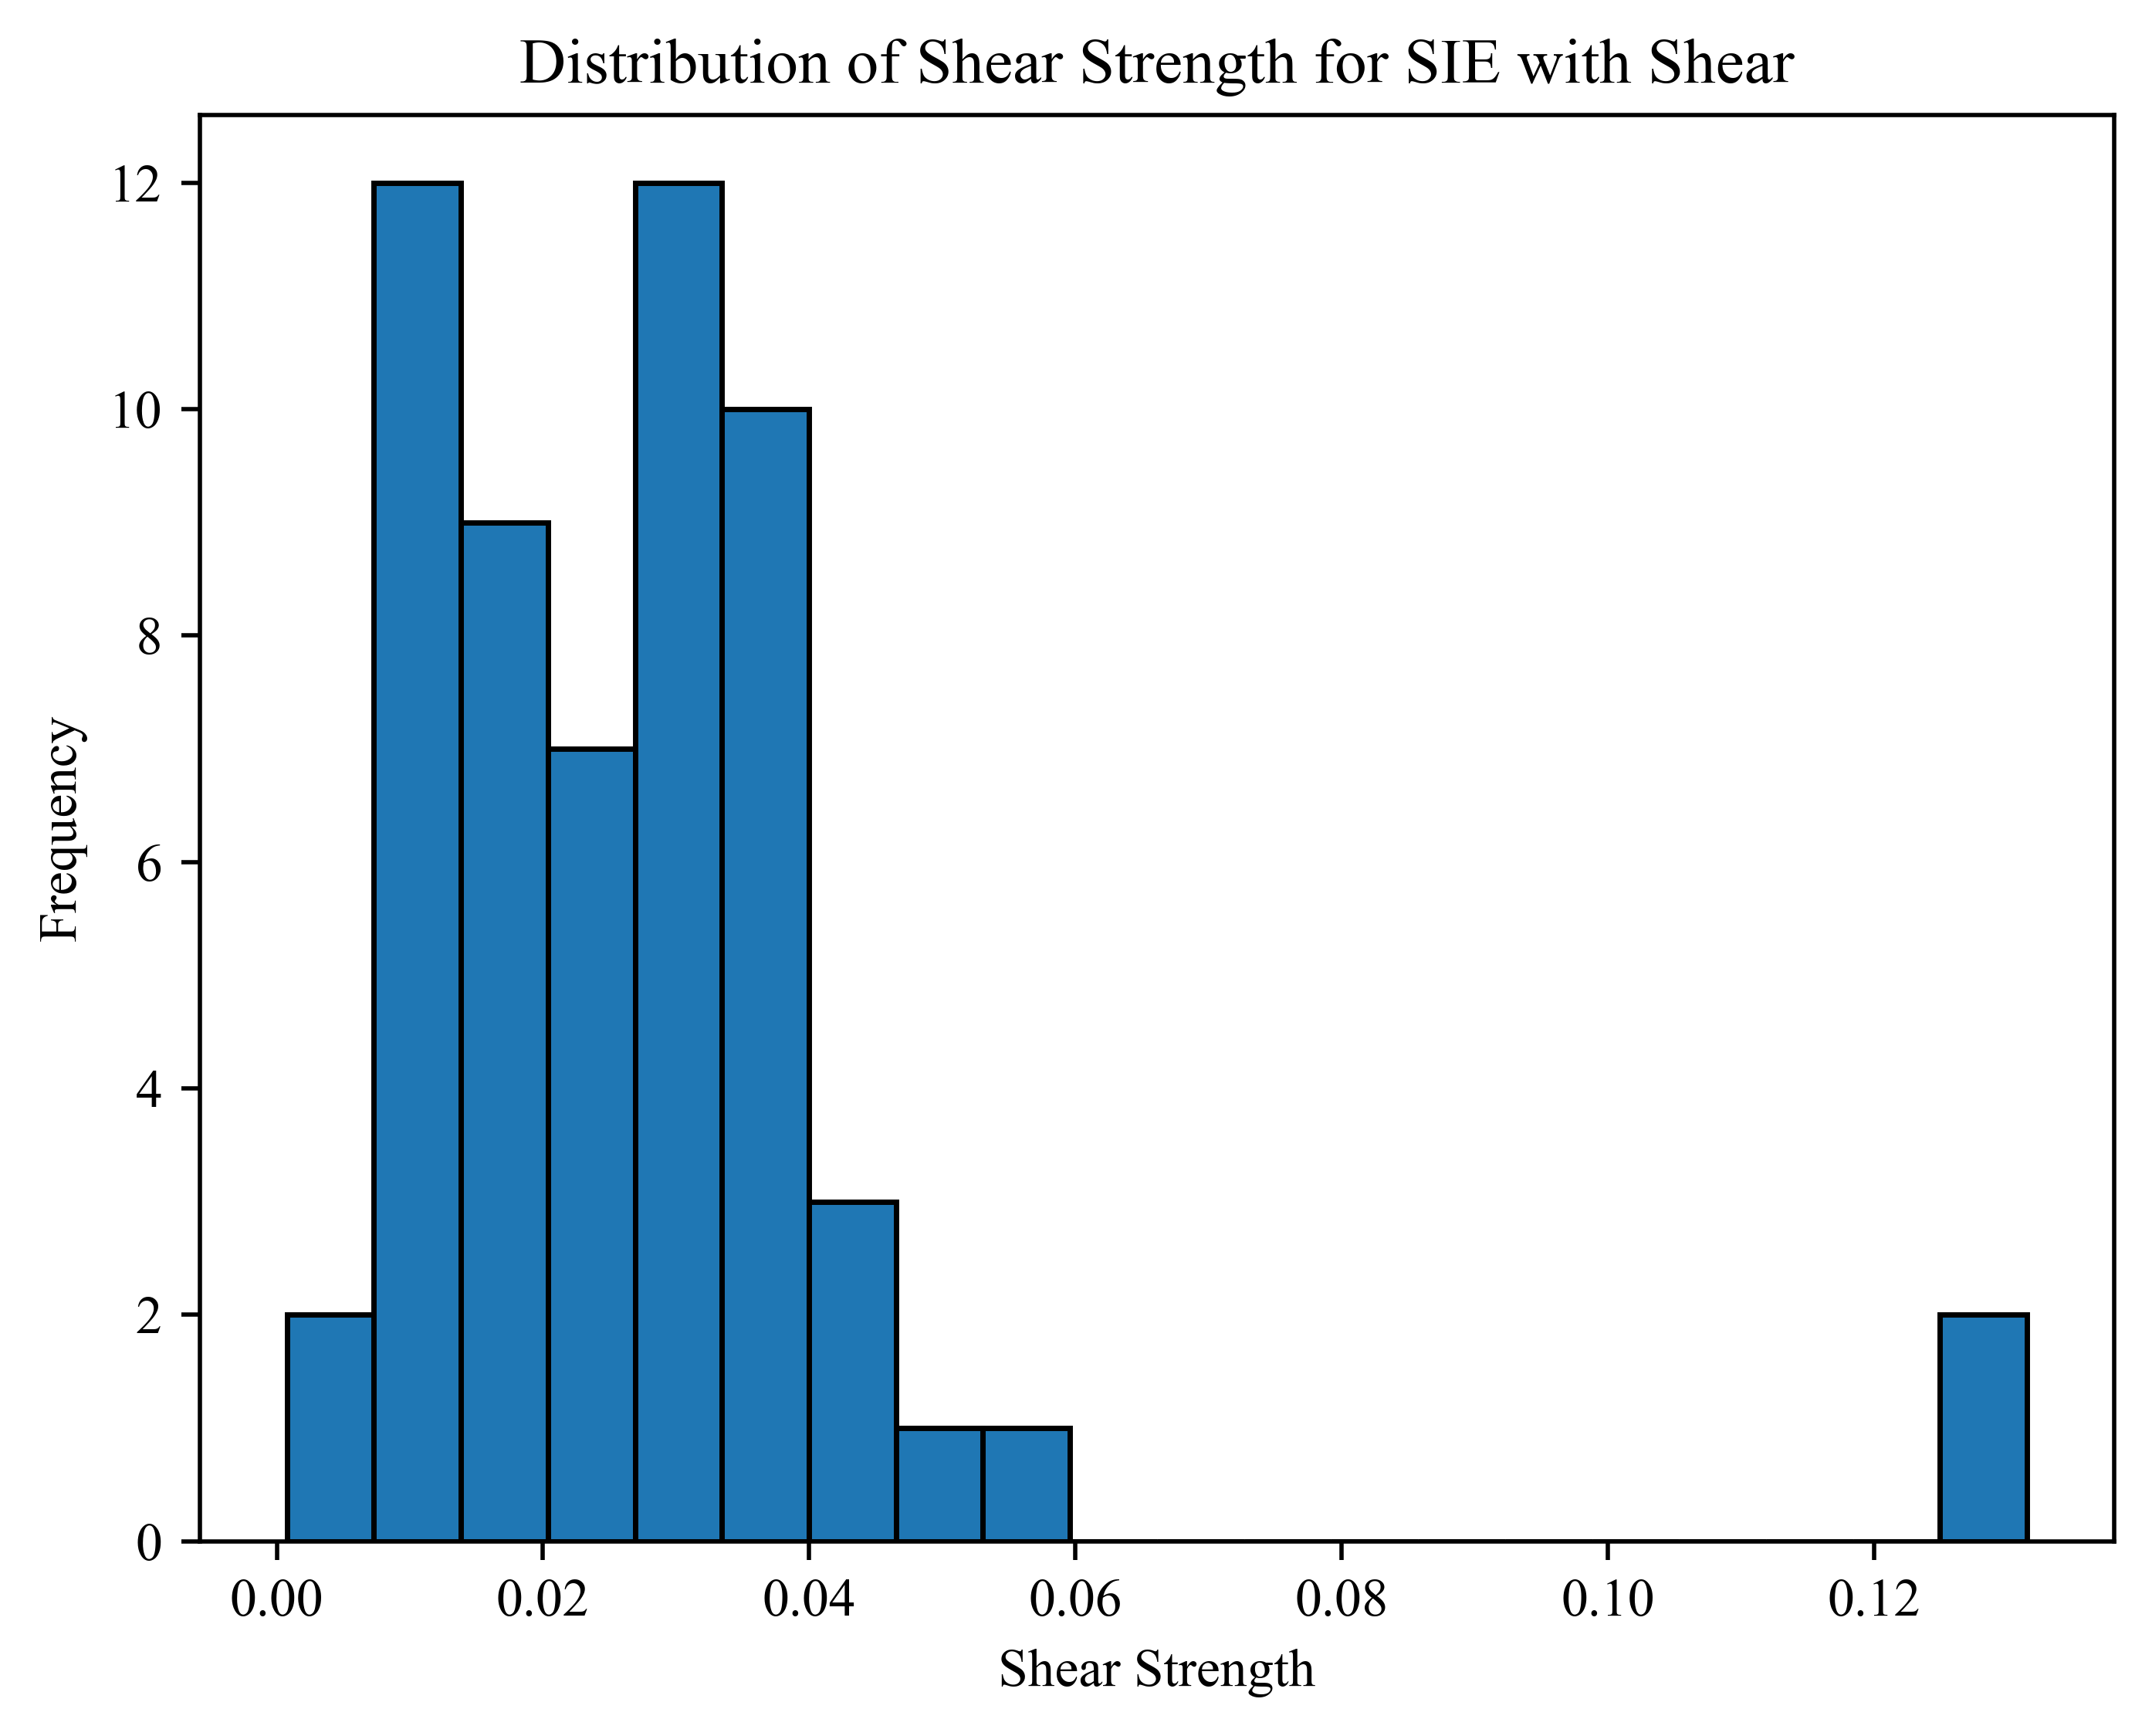

In [90]:
plt.hist(filtered_df['t_shear_str'], bins=20, edgecolor='black')
plt.xlabel('Shear Strength', color = 'k')
plt.ylabel('Frequency', color = 'k')
plt.title('Distribution of Shear Strength for SIE with Shear')
plt.show()

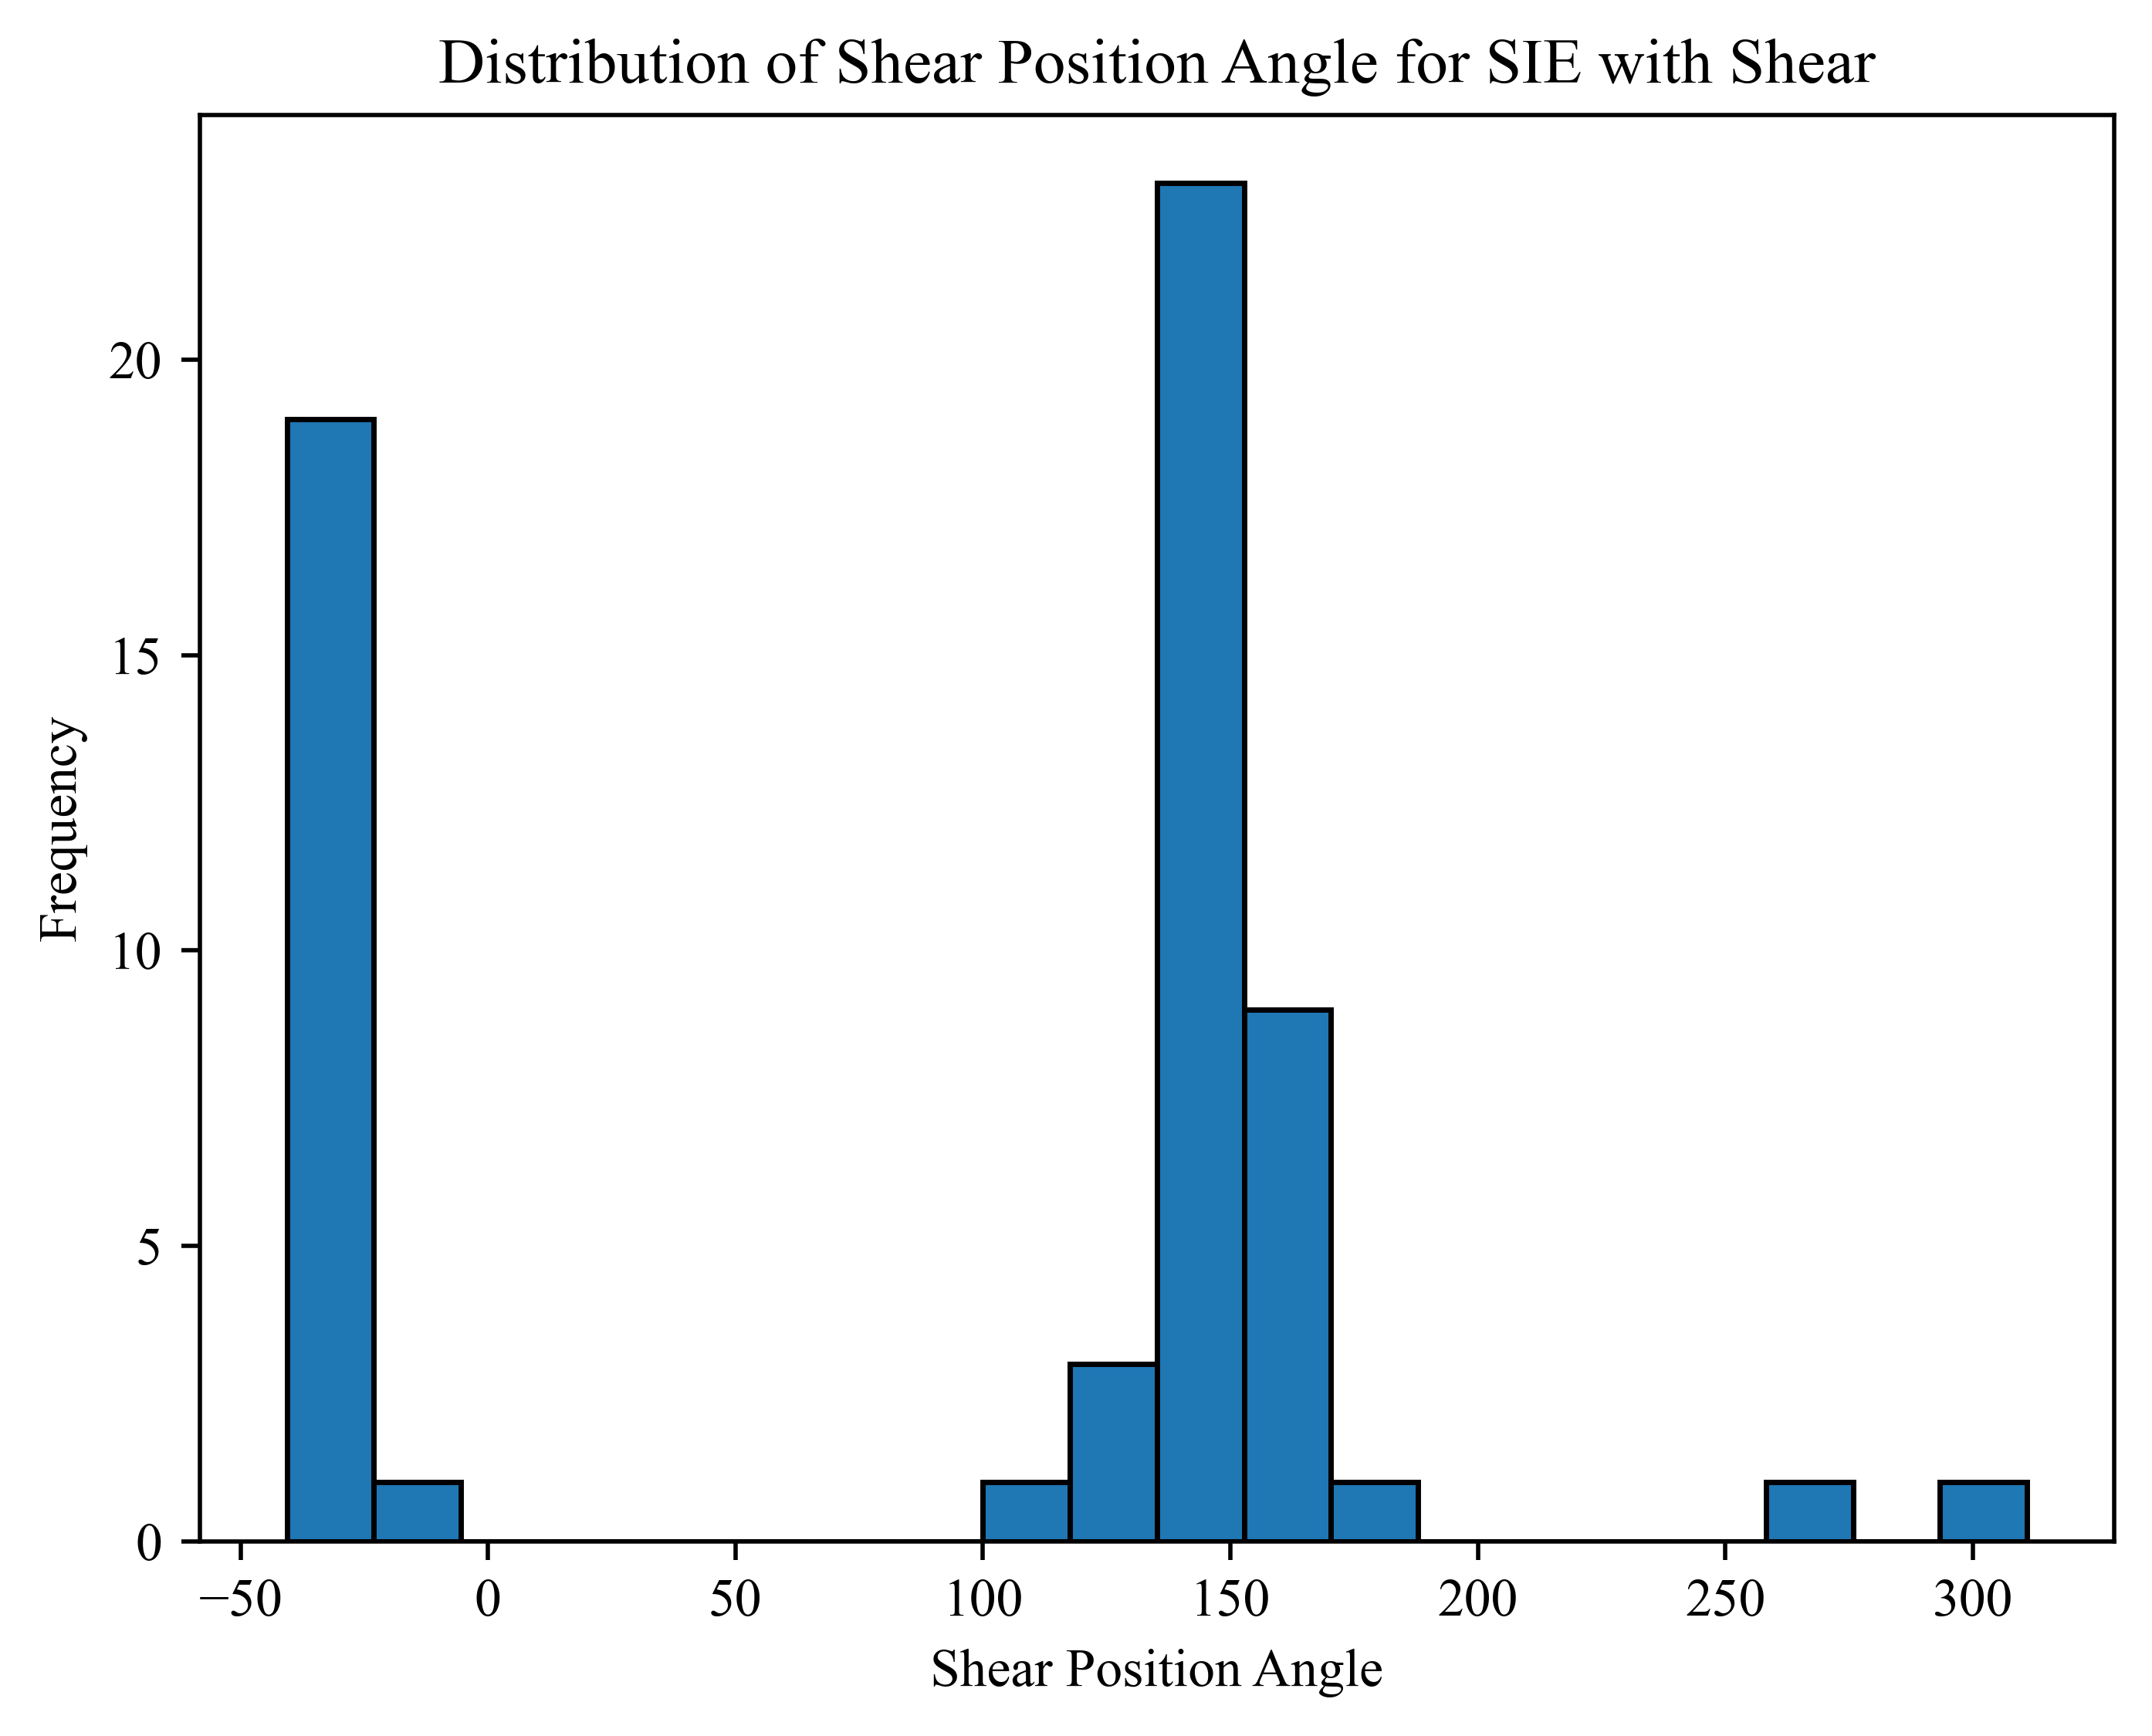

In [91]:
plt.hist(filtered_df['t_shear_pa'], bins=20, edgecolor='black')
plt.xlabel('Shear Position Angle', color = 'k')
plt.ylabel('Frequency', color = 'k')
plt.title('Distribution of Shear Position Angle for SIE with Shear')
plt.show()

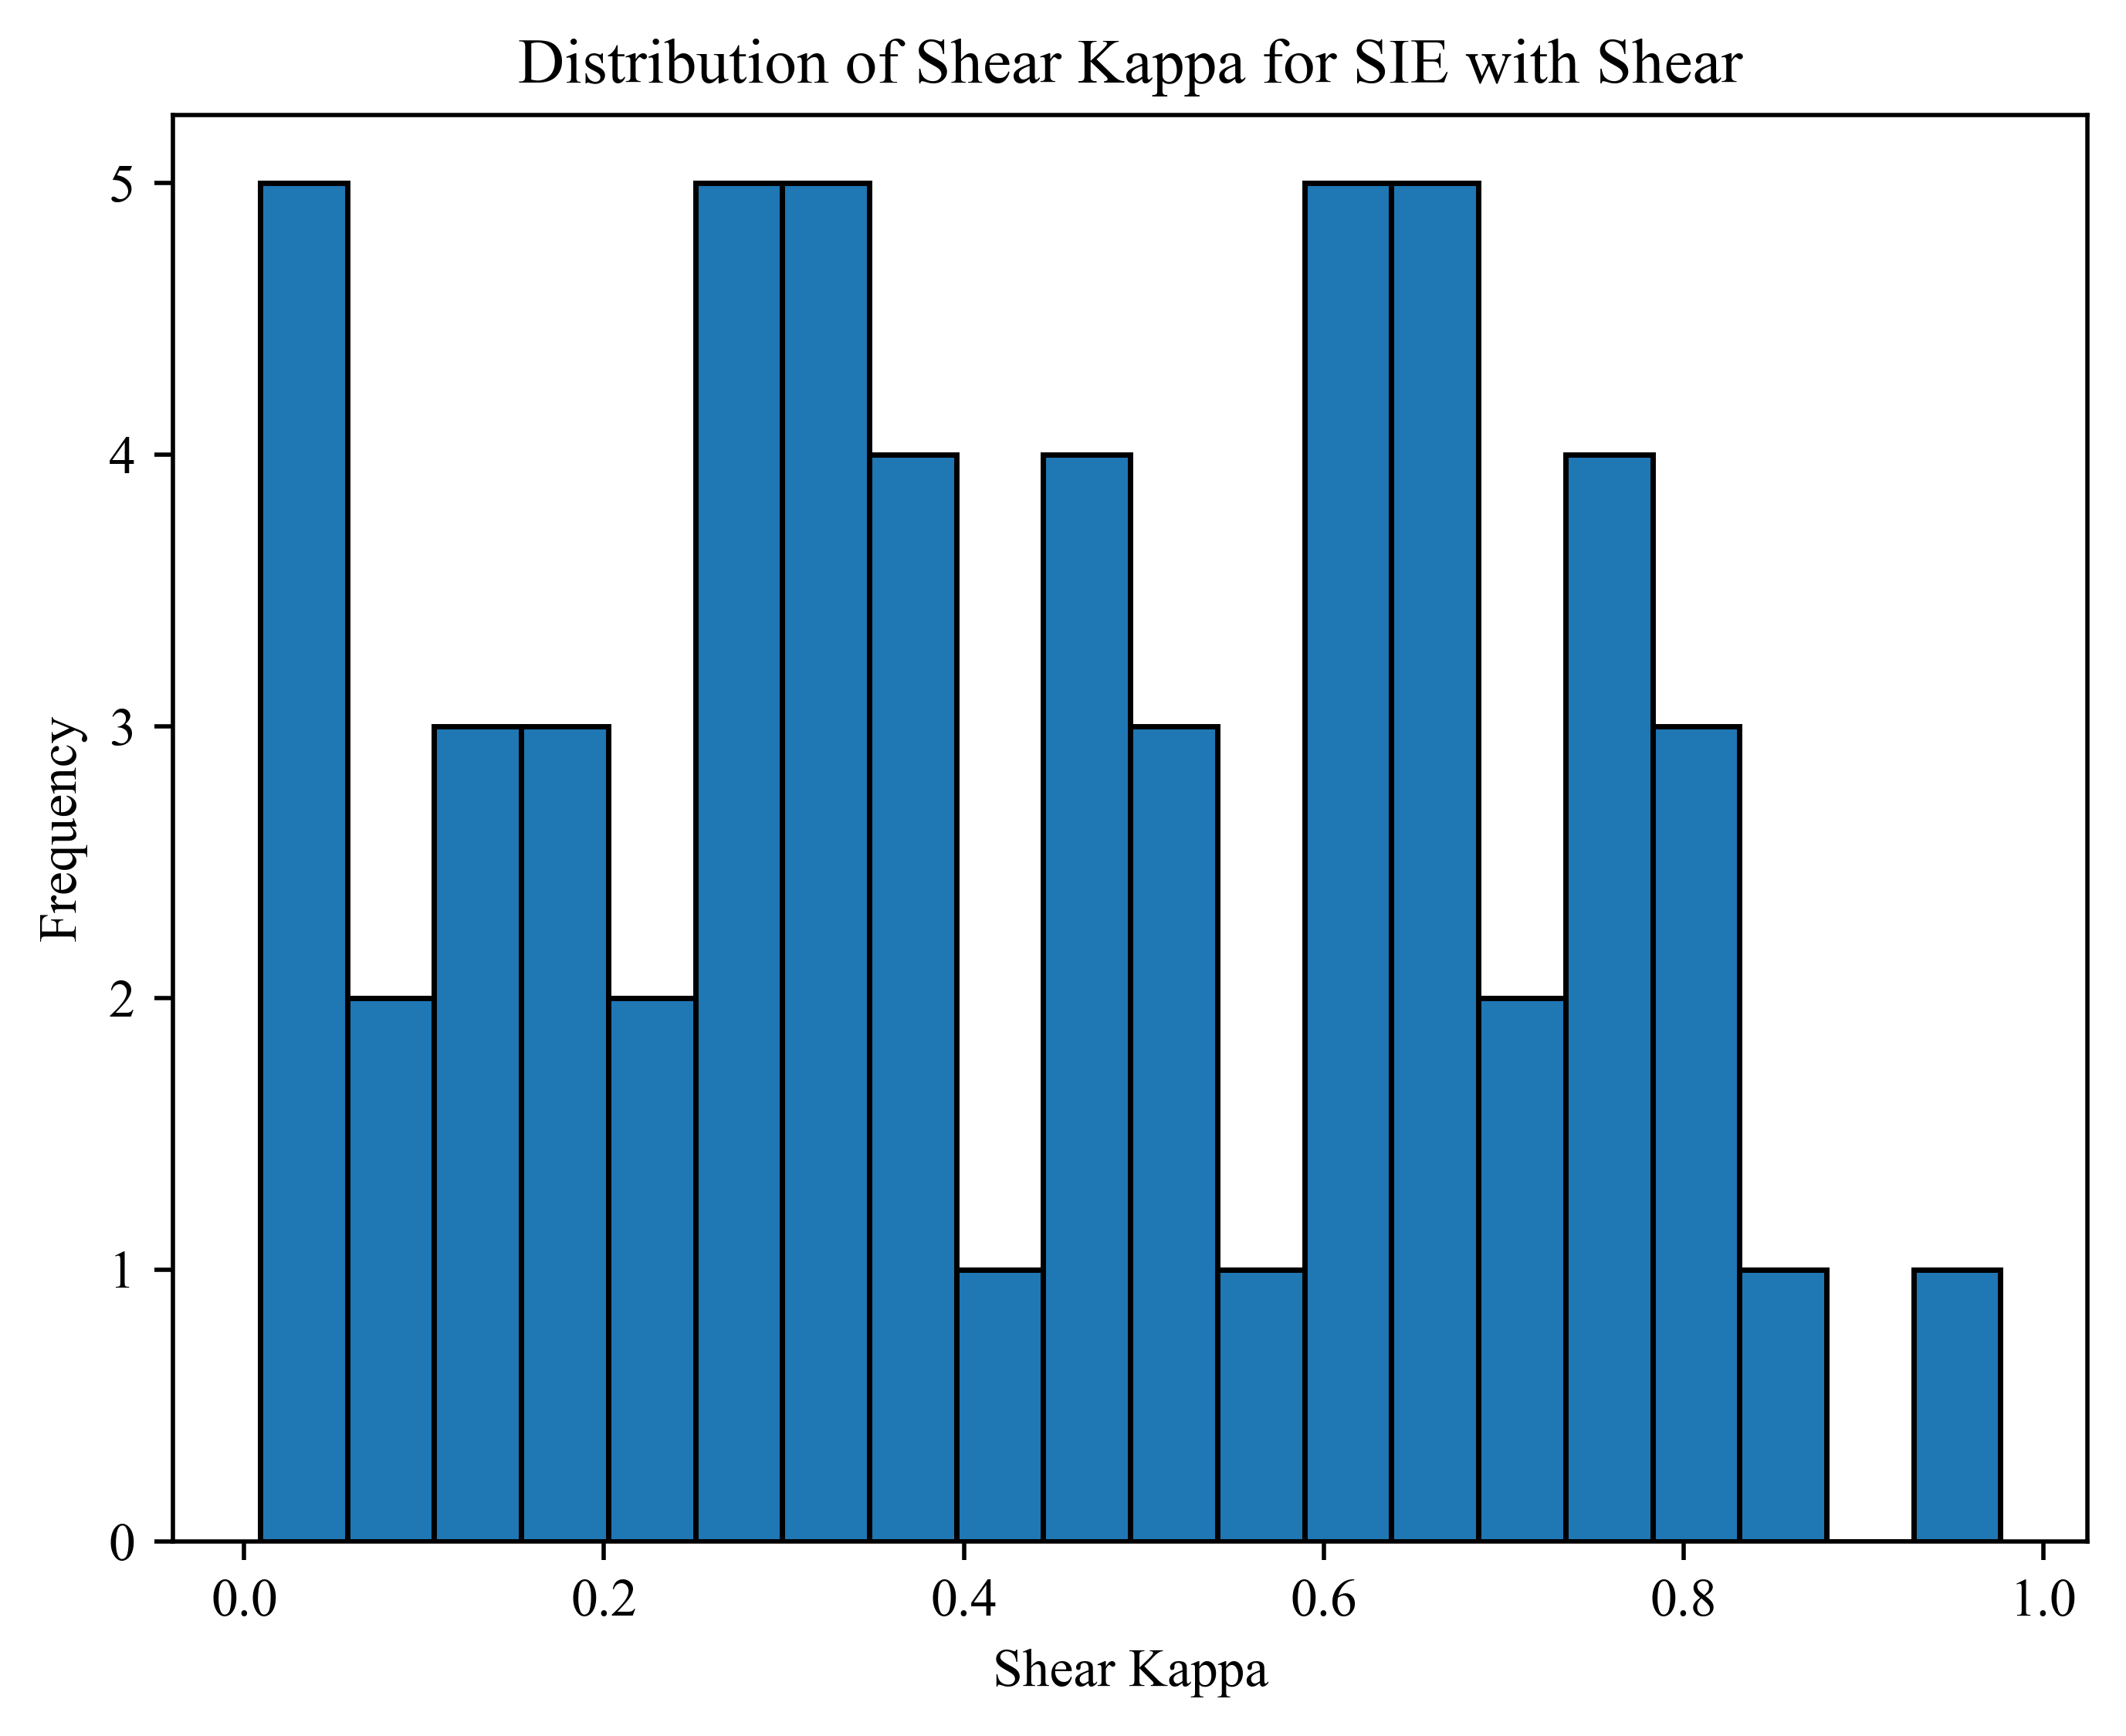

In [92]:
plt.hist(filtered_df['t_shear_kappa'], bins=20, edgecolor='black')
plt.xlabel('Shear Kappa', color = 'k')
plt.ylabel('Frequency', color = 'k')
plt.title('Distribution of Shear Kappa for SIE with Shear')
plt.show()

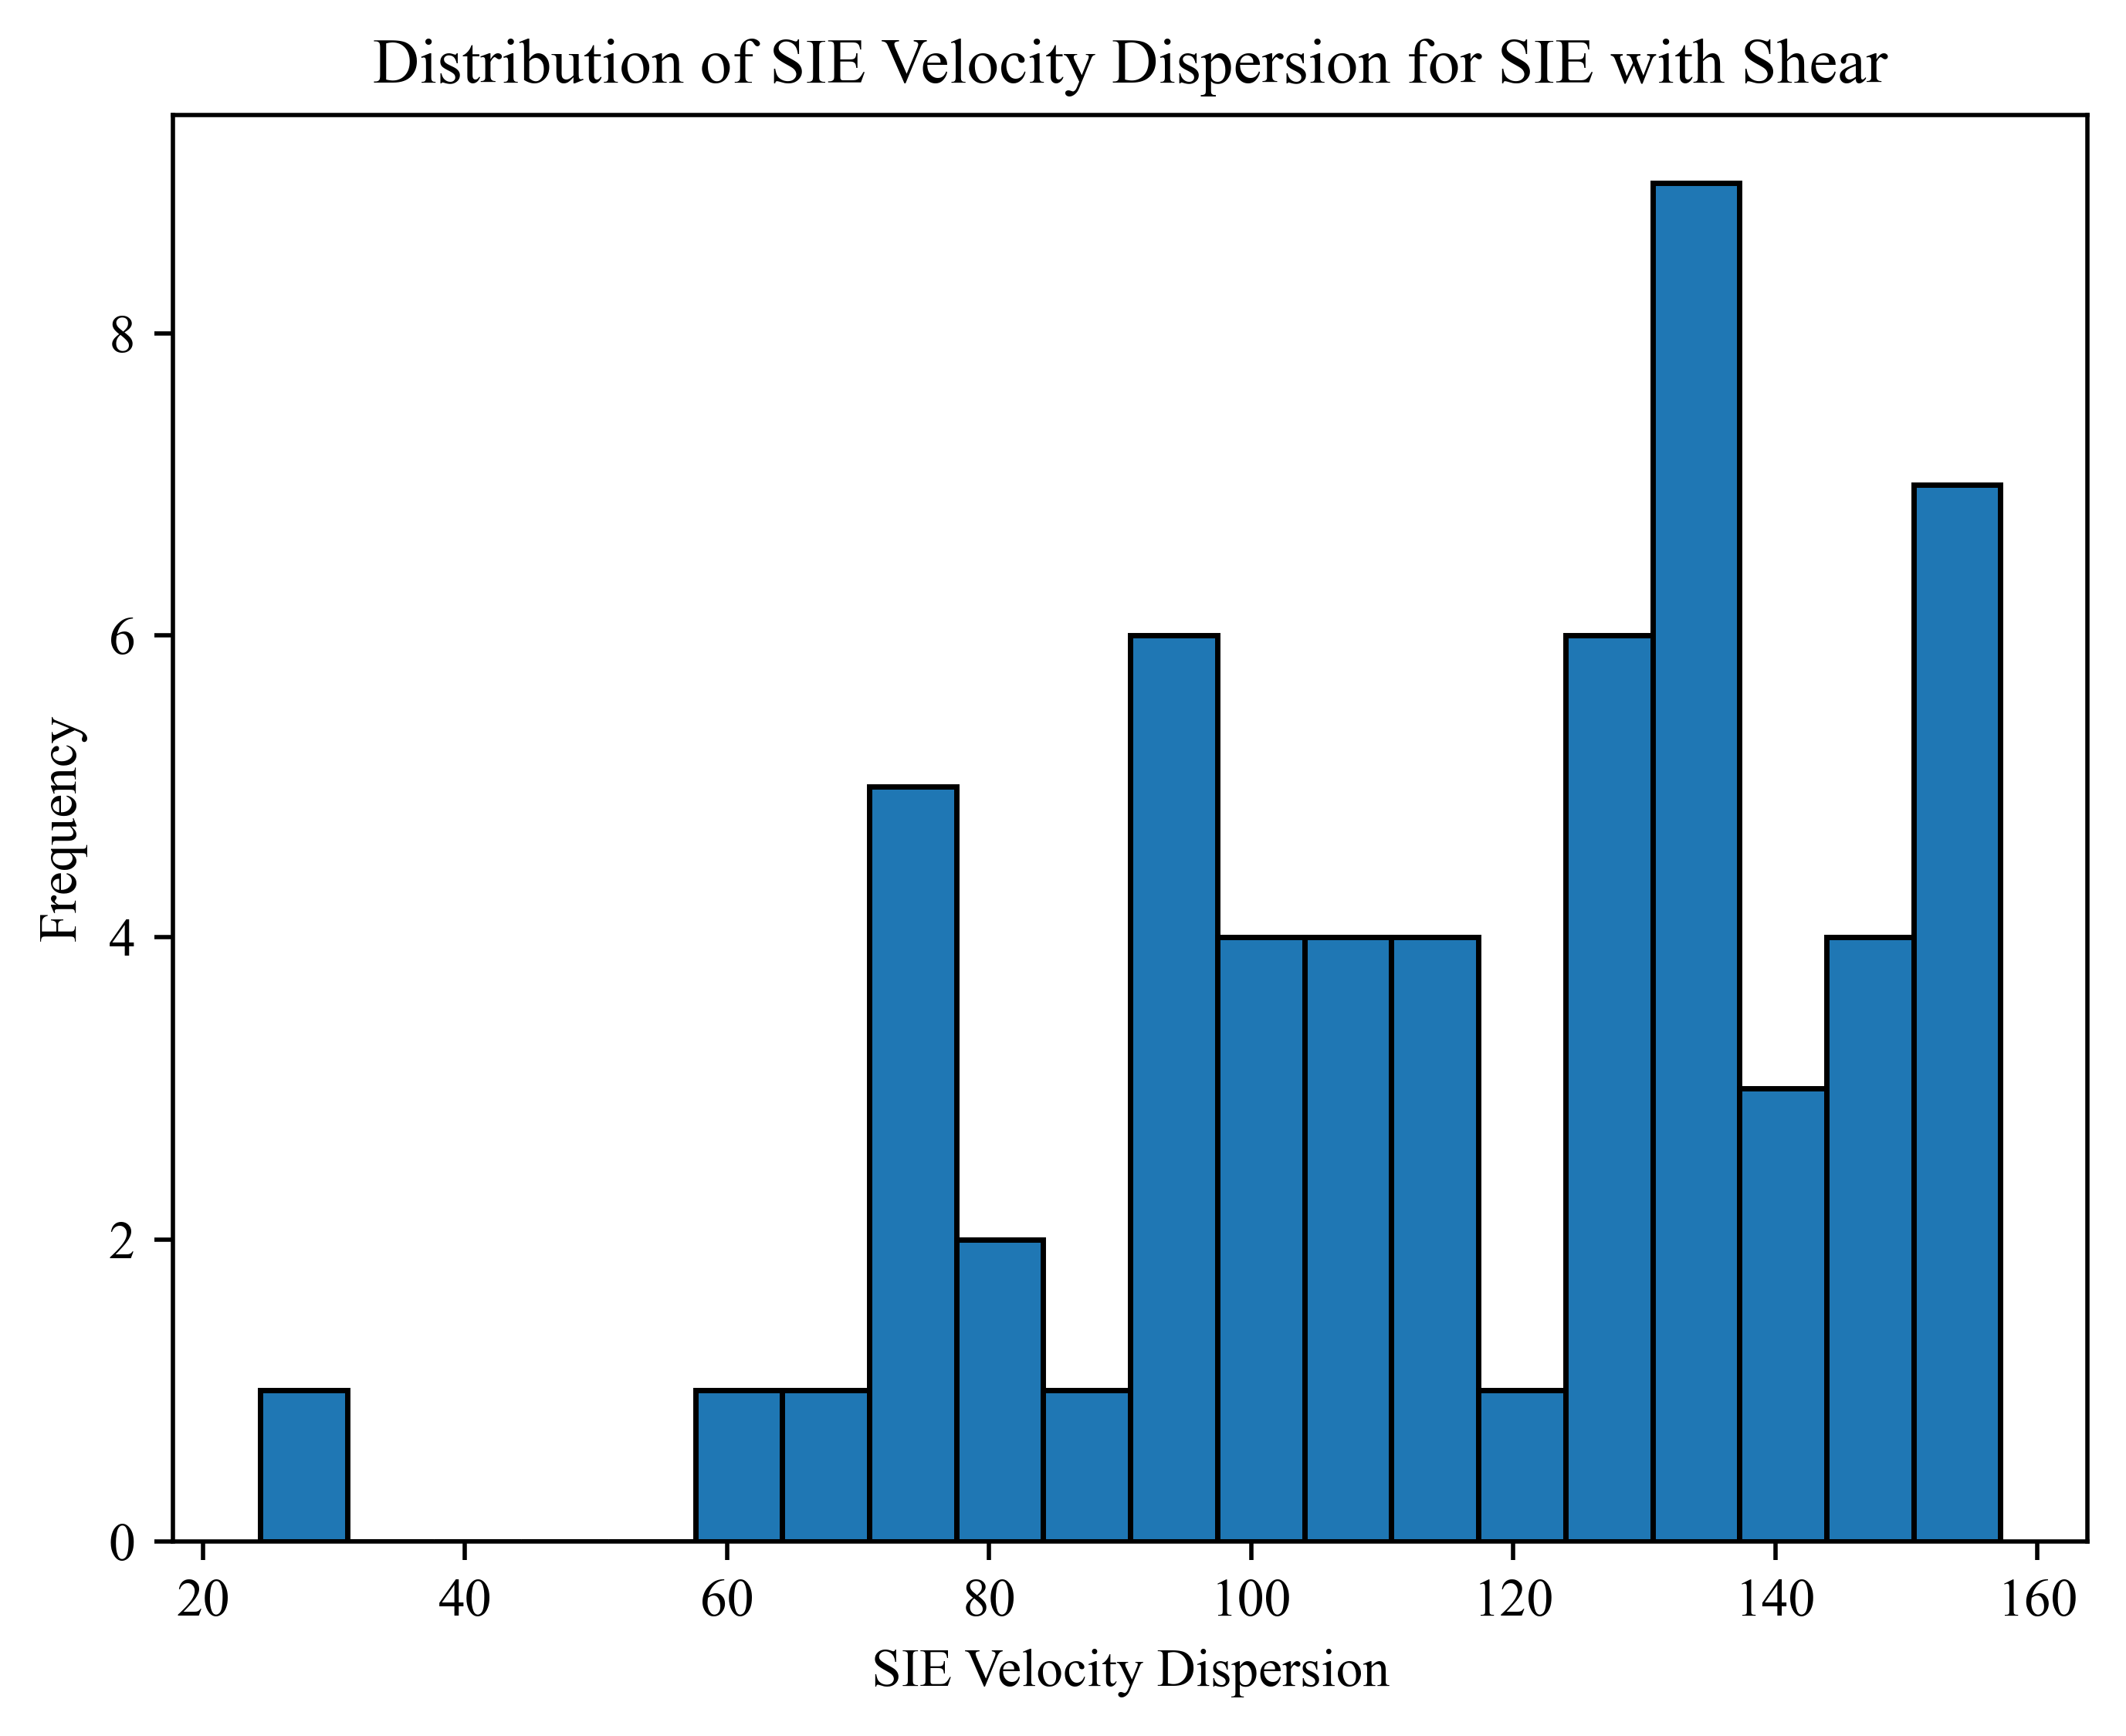

In [93]:
plt.hist(filtered_df['sie_vel_disp'], bins=20, edgecolor='black')
plt.xlabel('SIE Velocity Dispersion', color = 'k')
plt.ylabel('Frequency', color = 'k')
plt.title('Distribution of SIE Velocity Dispersion for SIE with Shear')
plt.show()

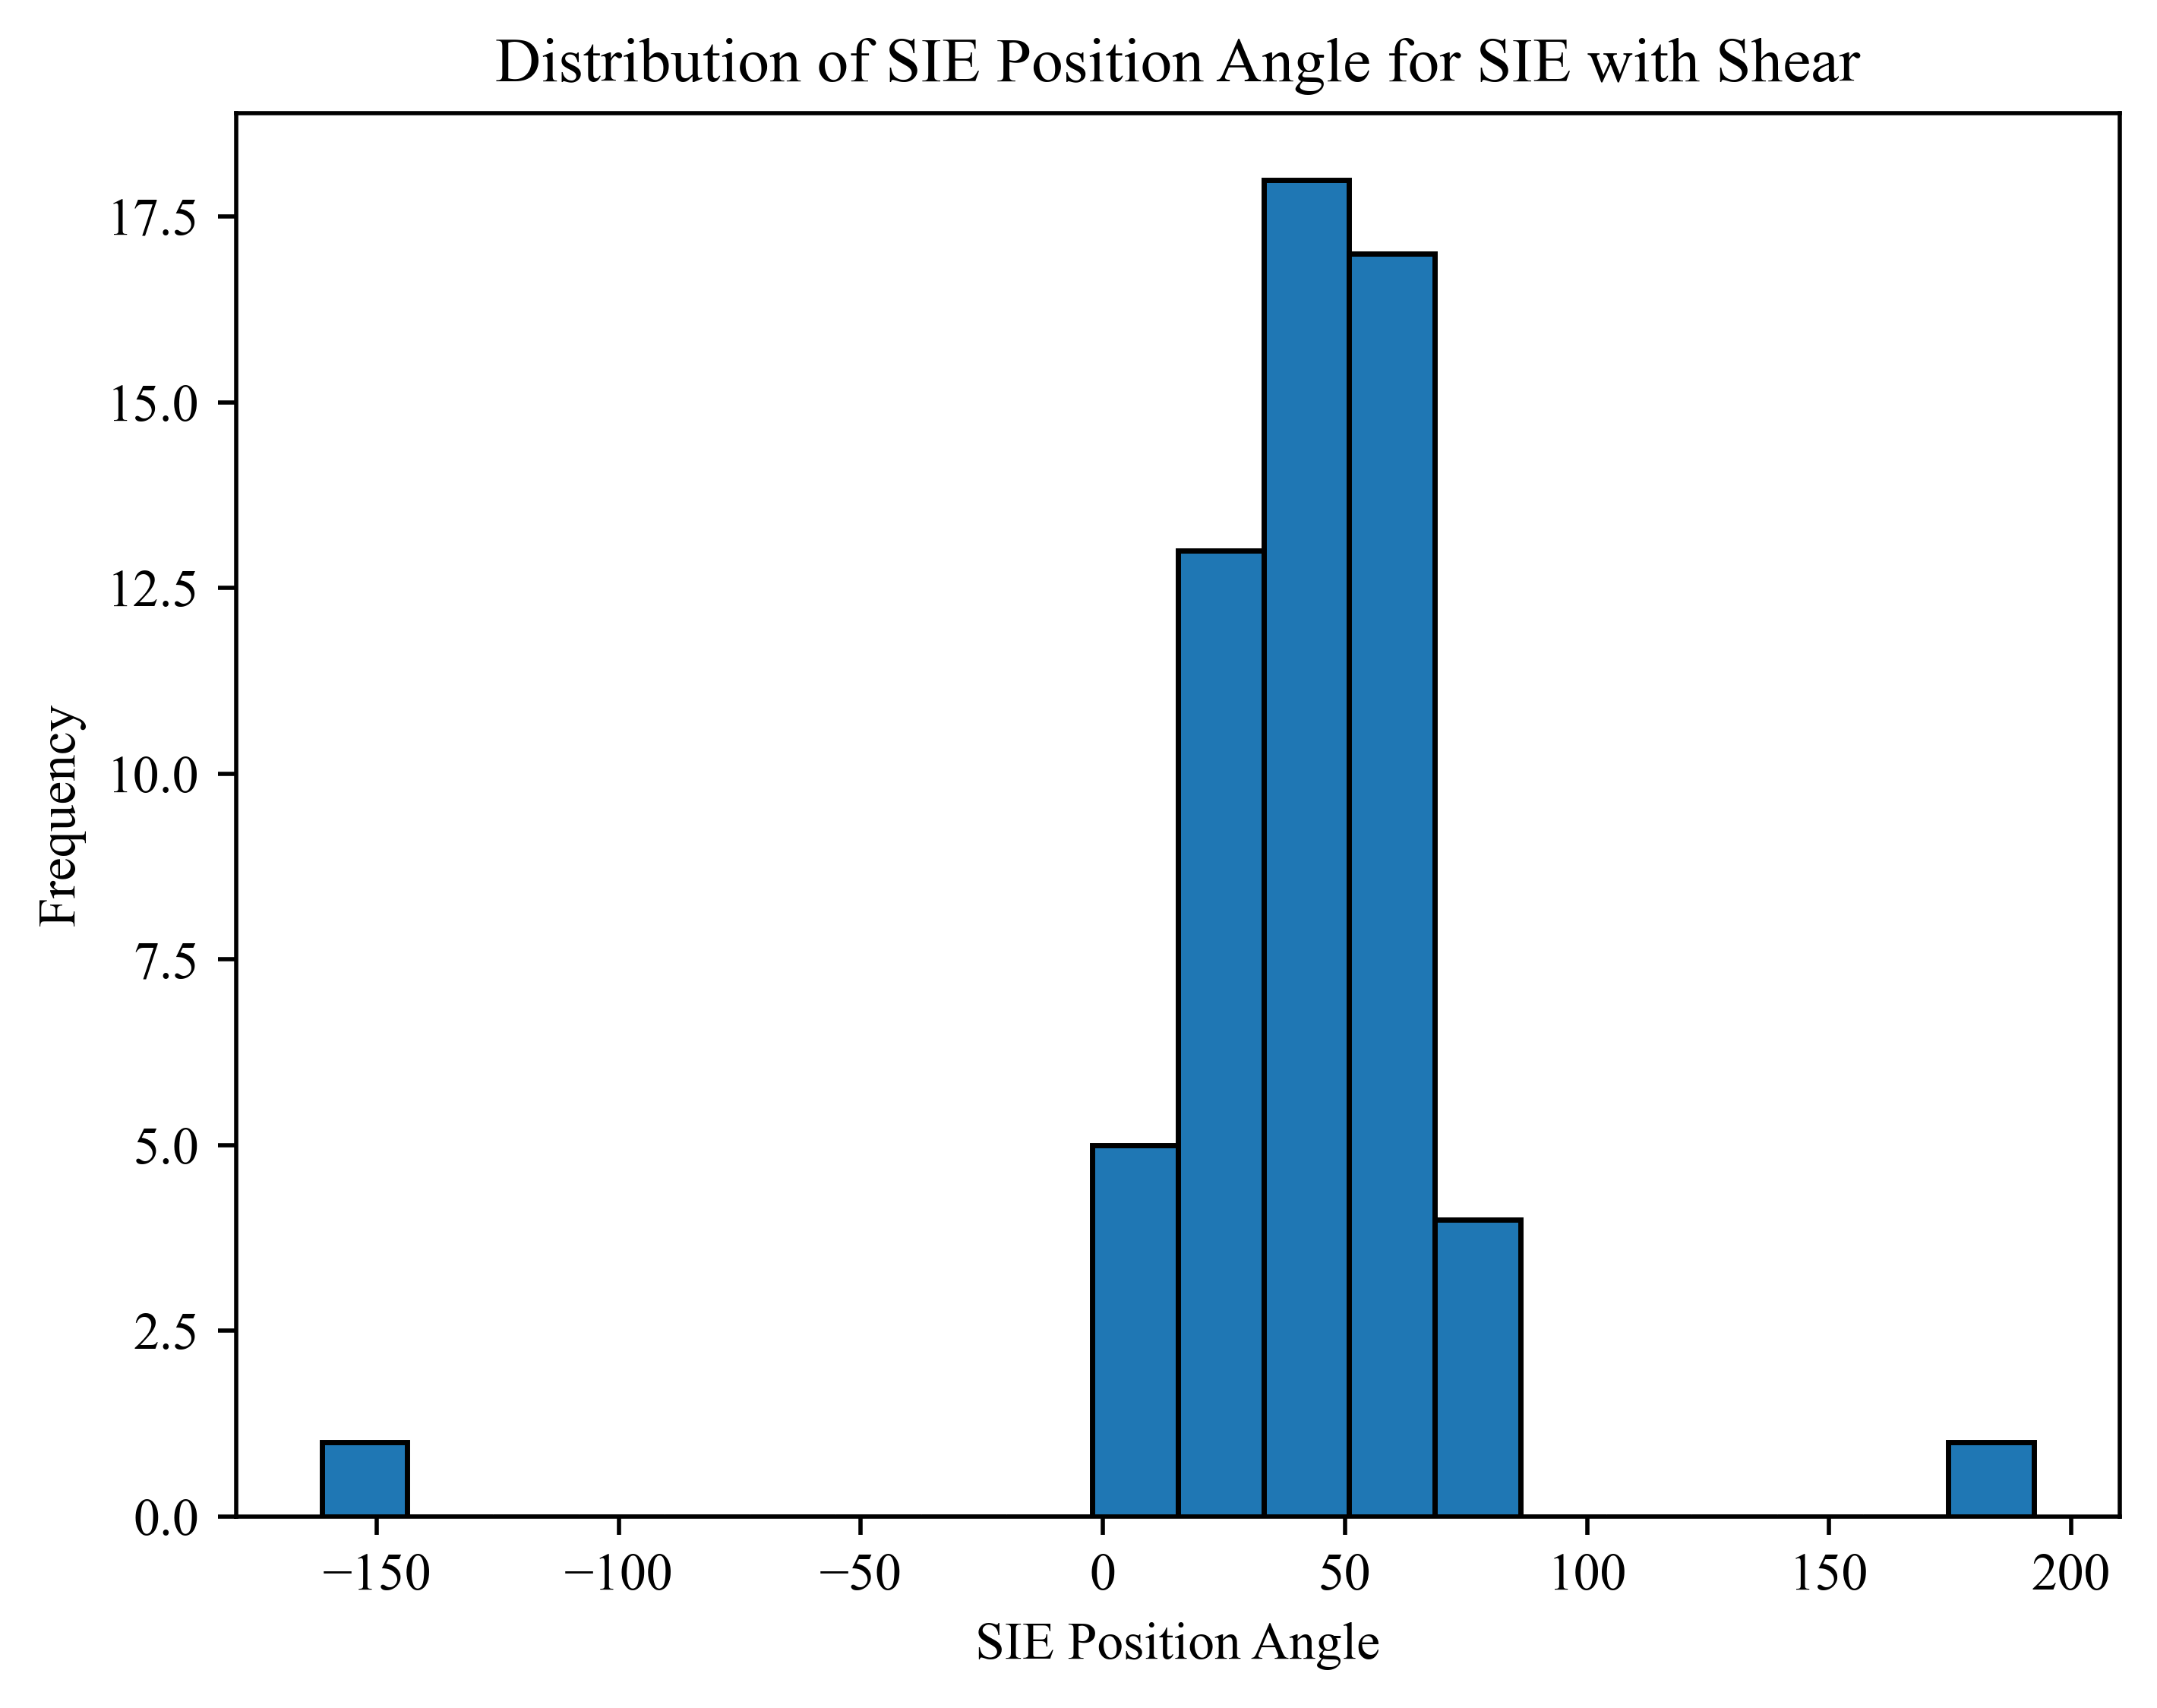

In [94]:
plt.hist(filtered_df['sie_pa'], bins=20, edgecolor='black')
plt.xlabel('SIE Position Angle', color = 'k')
plt.ylabel('Frequency', color = 'k')
plt.title('Distribution of SIE Position Angle for SIE with Shear')
plt.show()

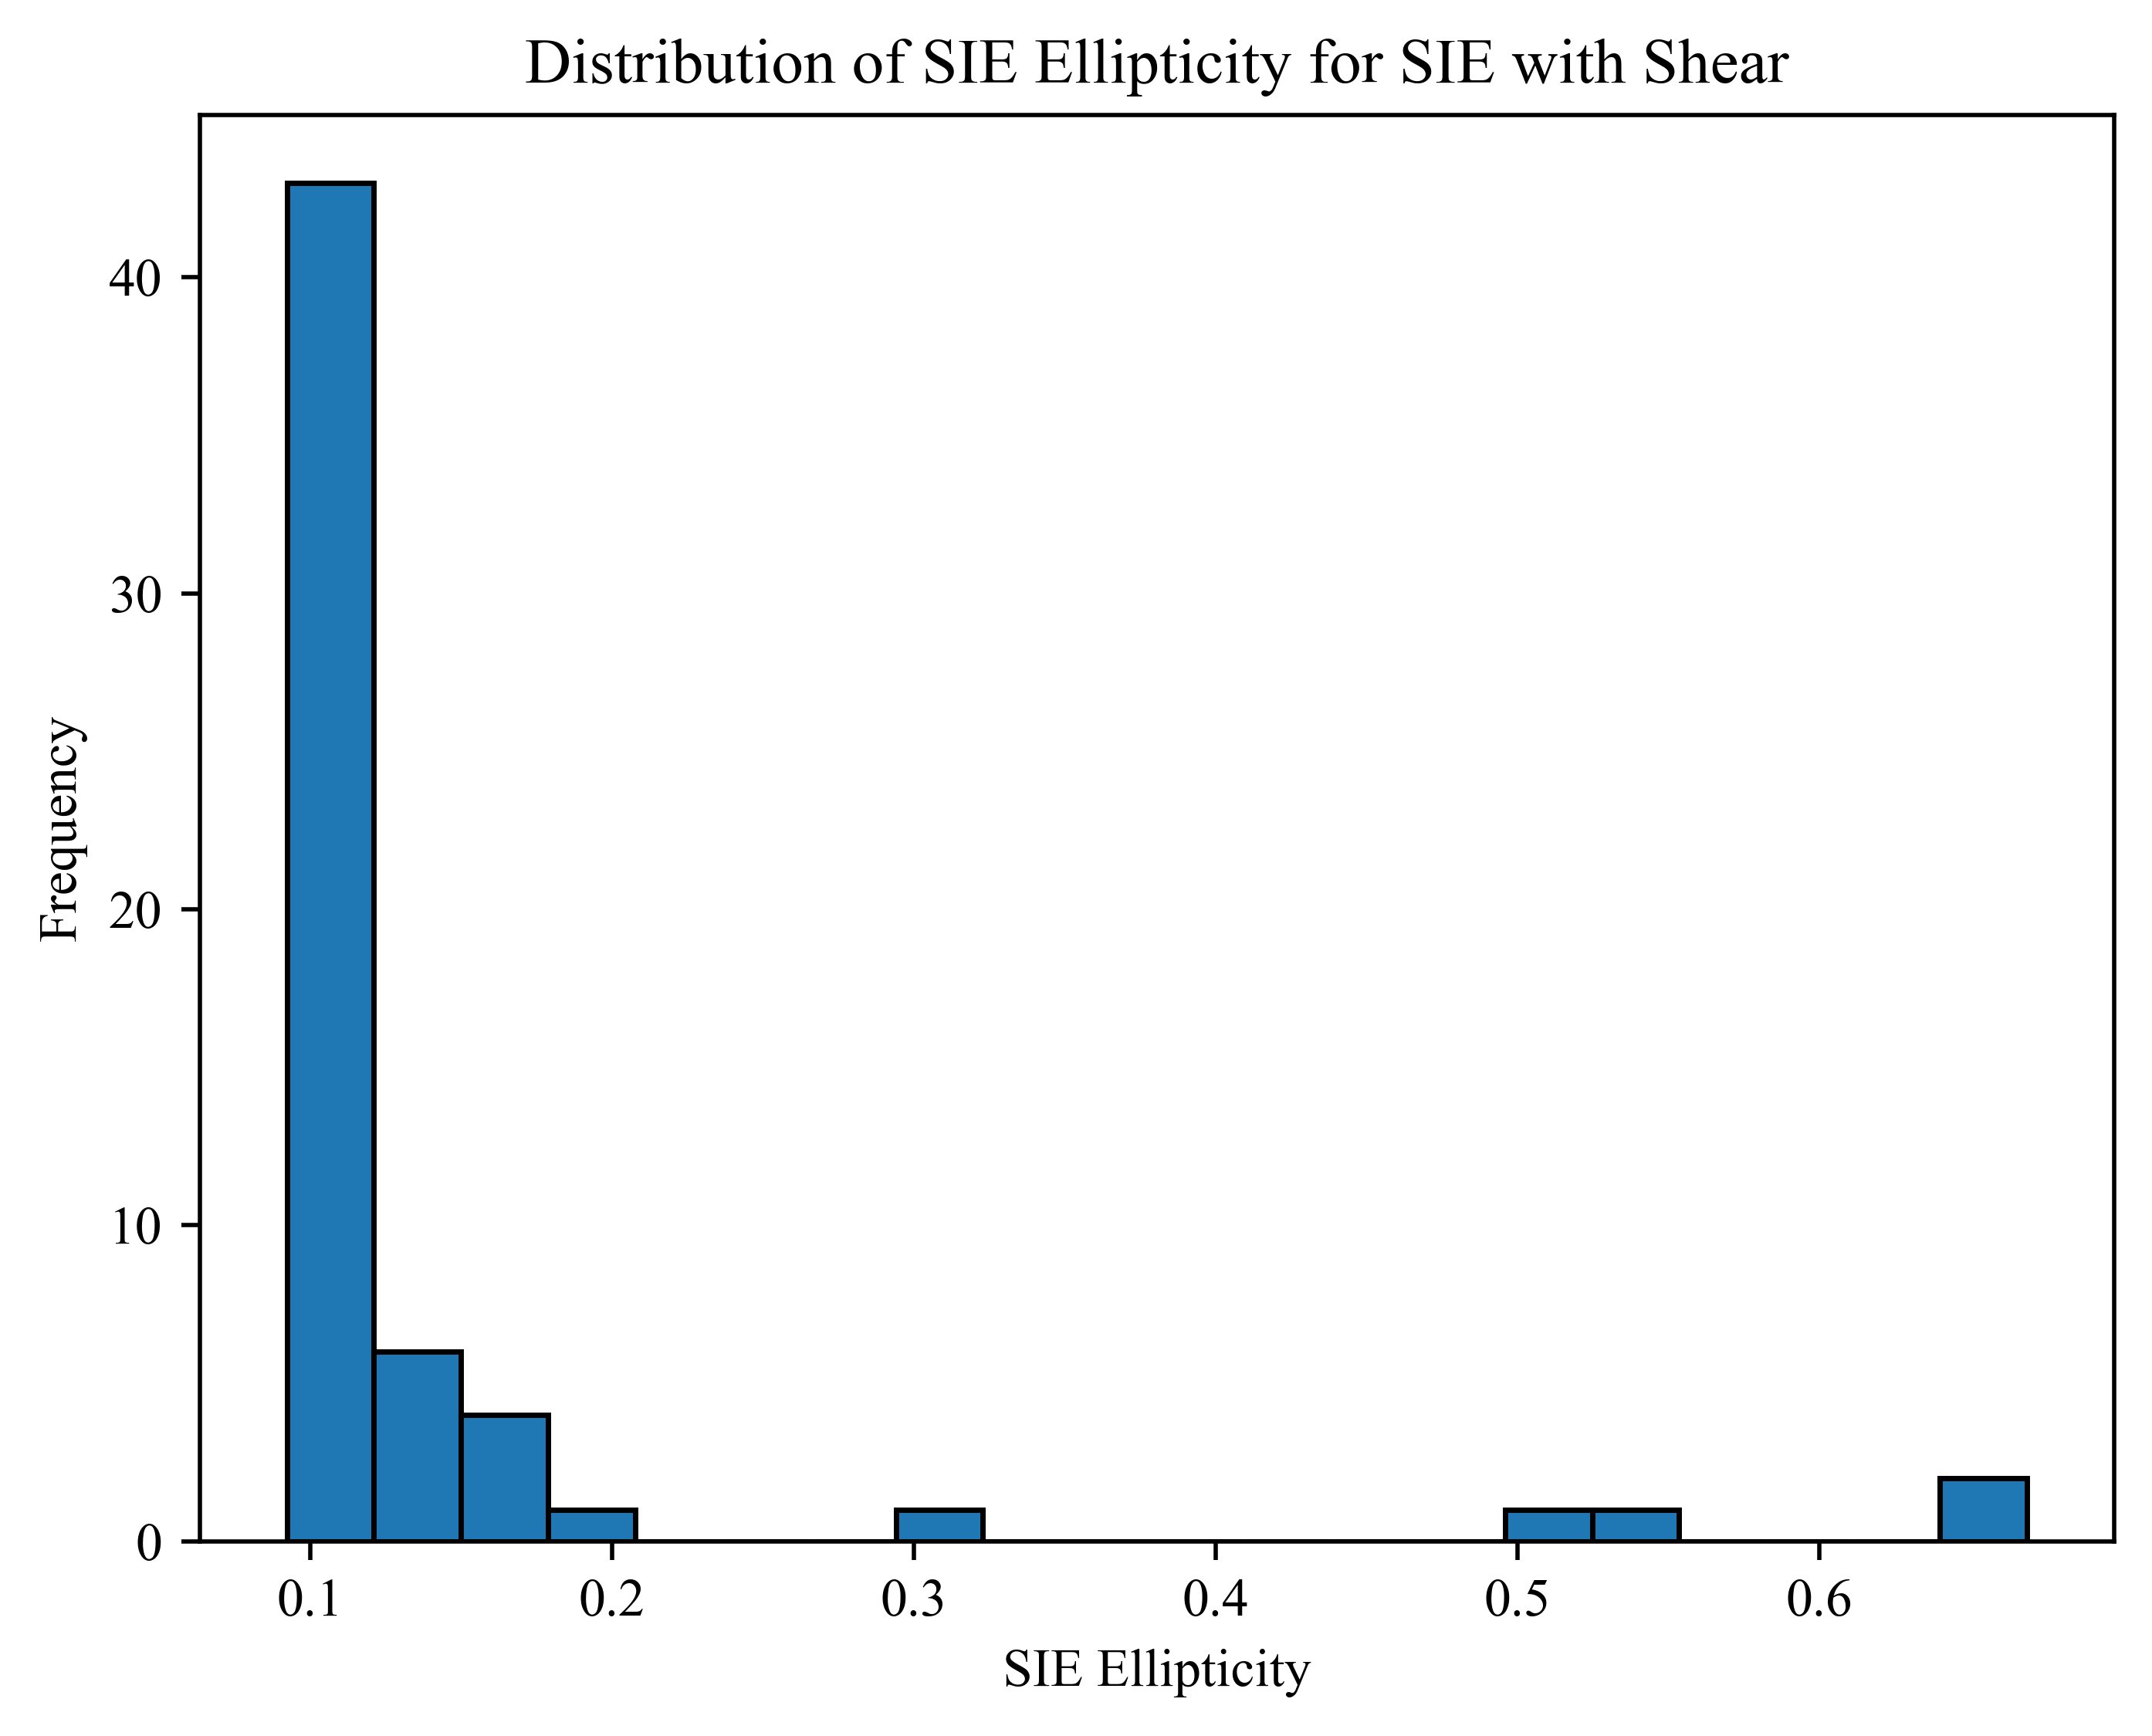

In [95]:
plt.hist(filtered_df['sie_ell'], bins=20, edgecolor='black')
plt.xlabel('SIE Ellipticity', color = 'k')
plt.ylabel('Frequency', color = 'k')
plt.title('Distribution of SIE Ellipticity for SIE with Shear')
plt.show()